## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline


from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K
from keras.applications import xception
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Softmax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [25]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

import glob
import pickle
import time

In [273]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback, TQDMCallback

## Preparation of data

Creating join table to easily access images from path

In [5]:
join_table = pd.DataFrame(sorted(glob.glob('./Images/*/*')), columns = ['path'])
join_table.head()

,path
0,./Images/n02085620-Chihuahua/n02085620_10074.jpg
1,./Images/n02085620-Chihuahua/n02085620_10131.jpg
2,./Images/n02085620-Chihuahua/n02085620_10621.jpg
3,./Images/n02085620-Chihuahua/n02085620_1073.jpg
4,./Images/n02085620-Chihuahua/n02085620_10976.jpg


In [8]:
join_table['file_name'] = join_table['path'].apply(lambda x: x.split('/')[-1].replace('.jpg',''))

In [11]:
join_table['labels'] = join_table['path'].apply(lambda x: x.split('/')[-2].split('-',1)[1])
join_table.labels.value_counts()

Maltese_dog                    252
Afghan_hound                   239
Scottish_deerhound             232
Pomeranian                     219
Bernese_mountain_dog           218
Irish_wolfhound                218
Samoyed                        218
Shih-Tzu                       214
Great_Pyrenees                 213
Leonberg                       210
basenji                        209
Tibetan_terrier                206
Sealyham_terrier               202
Airedale                       202
EntleBucher                    202
pug                            200
Saluki                         200
Lakeland_terrier               197
cairn                          197
Australian_terrier             196
papillon                       196
Norwegian_elkhound             196
chow                           196
Newfoundland                   195
beagle                         195
Siberian_husky                 192
Ibizan_hound                   188
Blenheim_spaniel               188
bloodhound          

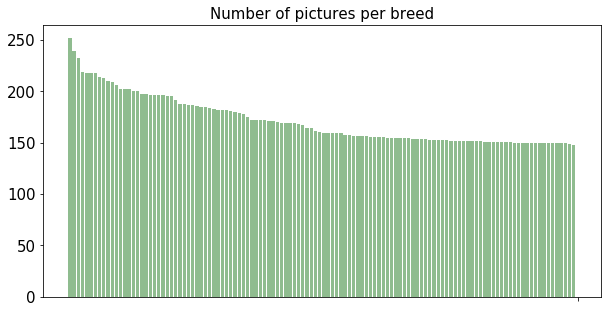

In [48]:
a = (join_table['labels'].value_counts())
fig = plt.figure(figsize = (10,5))
plt.bar(x = a.index, height = a, color = 'darkseagreen')
plt.xticks('')
plt.title('Number of pictures per breed', fontsize = 15)
plt.yticks(fontsize = 15)
fig.savefig("count.png", transparent = True)

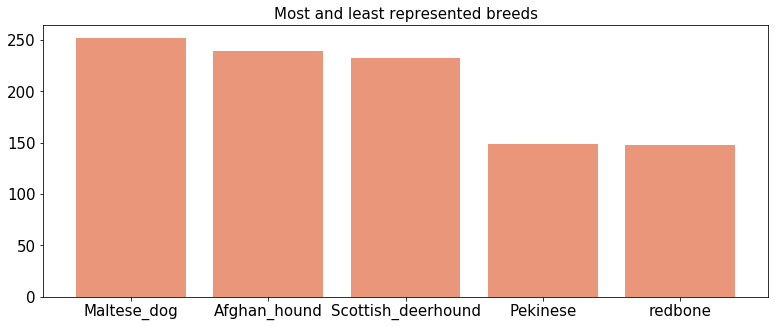

In [47]:
fig = plt.figure(figsize = (13,5))
plt.bar(x = a[(a > 230) | (a < 150)].index, height = a[(a > 230) | (a < 150)], color = 'darksalmon')
plt.xticks(fontsize = 15)
plt.title('Most and least represented breeds', fontsize = 15)
plt.yticks(fontsize = 15)
fig.savefig("most_rep.png", transparent = True)

In [12]:
join_table.head()

,path,file_name,labels
0,./Images/n02085620-Chihuahua/n02085620_10074.jpg,n02085620_10074,Chihuahua
1,./Images/n02085620-Chihuahua/n02085620_10131.jpg,n02085620_10131,Chihuahua
2,./Images/n02085620-Chihuahua/n02085620_10621.jpg,n02085620_10621,Chihuahua
3,./Images/n02085620-Chihuahua/n02085620_1073.jpg,n02085620_1073,Chihuahua
4,./Images/n02085620-Chihuahua/n02085620_10976.jpg,n02085620_10976,Chihuahua


Save join table to file

In [566]:
join_table.to_csv('mac_join_table.csv', index = False)

In [22]:
len(join_table.index)

20580

Creating helper functions to display images from file

In [14]:
def read_img(index, size = (224,224)):
    """Read and resize image from path"""
    # reading with keras preprocessing to assure right format for later standardizartion
    img = image.load_img(join_table.loc[index].values[0], target_size=size)
    # img_to_array adds information about number of channels
    img = image.img_to_array(img)
    return img

In [15]:
def show_image(index):
    """Returns image from specified index"""
    fig, ax = plt.subplots(1, figsize=(4, 4))
    img = image.load_img(join_table.loc[index].values[0], target_size=(224, 224))
    ax.imshow(img)
    return plt.show()

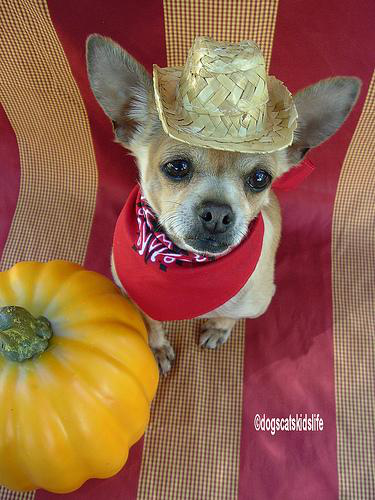

In [239]:
image.load_img(join_table.loc[7].values[0])

#### Converting all images to array of tensors and preprocess them to standardize the input for predictions

Expanding dimensions to get the whole batch of images (samples, size1, size2, channels)

For normalization ResNet is using caffe style - centralizing all values

In [26]:
all_images_to_array = np.zeros((len(join_table.index), 224, 224, 3), dtype='float32')
for i in tqdm_notebook((join_table.index)):
    img = read_img(i)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    all_images_to_array[i] = x
print('All Images shape: {} size: {:,}'.format(all_images_to_array.shape, all_images_to_array.size))


All Images shape: (20580, 224, 224, 3) size: 3,097,866,240


In [27]:
type(all_images_to_array)

numpy.ndarray

In [28]:
all_images_to_array.shape

(20580, 224, 224, 3)

Saving the preprocessed array to file - this will take a while

In [29]:
np.save('preprocessed_array', all_images_to_array)

The whole array takes 12GB of disk space

## Feature extraction

In this project I am using ResNet50 pre-trained model with weights from imagenet dataset. I will be using transfer learning to classify dog breeds based on the dog picture. I am removing last layer of the ResNet model and will be using the features from the previous layer for classification with other models (so called bottleneck features).

In [30]:
model_RN50 = ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=1000)

94658560/94653016 [==============================] - 20s 0us/step


In [35]:
rand_idx = np.random.random(len(all_images_to_array))
train_idx_2 = rand_idx < 0.8
valid_idx_2 = rand_idx >= 0.8

For classification of the dog breeds I will convert table with all labels to one-hot-encoded table

In [37]:
join_table['target'] = 1

In [41]:
y_table = join_table.reset_index().pivot('index','labels', 'target').fillna(0)

Save the table

In [562]:
y_table.to_csv('all_one_hot_encoded.csv', index = False)

In [563]:
y_table.shape

(20580, 120)

In [42]:
y_train = y_table[train_idx_2]
y_val = y_table[valid_idx_2]

In [43]:
X_train = all_images_to_array[train_idx_2]
X_val = all_images_to_array[valid_idx_2]

In [44]:
print((X_train.shape, X_val.shape, y_train.shape, y_val.shape))

((16532, 224, 224, 3), (4048, 224, 224, 3), (16532, 120), (4048, 120))


Predict 2048 features for every image in my database, separately for train and validation set.

In [ ]:
train_RN50 = model_RN50.predict(X_train, batch_size=32, verbose=1)
valid_RN50 = model_RN50.predict(X_val, batch_size=32, verbose=1)

In [49]:
print('RN50 train bottleneck features shape: {} size: {:,}'.format(train_RN50.shape, train_RN50.size))
print('RN50 valid bottleneck features shape: {} size: {:,}'.format(valid_RN50.shape, valid_RN50.size))

RN50 train bottleneck features shape: (16532, 2048) size: 33,857,536
RN50 valid bottleneck features shape: (4048, 2048) size: 8,290,304


Saving features for all images to file

In [50]:
train_arr = train_RN50.copy()
np.save('train_arr_rn50', train_arr)
valid_arr = valid_RN50.copy()
np.save('valid_arr_rn50', valid_arr)

## Classification modeling

### First model - Logistic regression

In [53]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=2)

# fitting the model to train set
logreg.fit(train_arr, (y_train * range(120)).sum(axis=1))

# running predictions on validation set - predicting classes and their probabilites
valid_probs = logreg.predict_proba(valid_arr)
valid_preds = logreg.predict(valid_arr)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy metrics for first logistic regression:

In [55]:
print('Validation RN50 LogLoss {}'.format(log_loss(y_val, valid_probs)))
print('Validation RN50 Accuracy {}'.format(accuracy_score((y_val * range(120)).sum(axis=1), valid_preds)))

Validation RN50 LogLoss 0.8881048596132193
Validation RN50 Accuracy 0.7939723320158103


Creating a list of correct classes for validation set

In [65]:
valid_breeds= (y_val * range(120)).sum(axis=1)

In [179]:
label_list = pd.concat([pd.DataFrame([col], columns=['label_name']) for col in list(y_table.columns)], ignore_index=True)

In [564]:
label_list.to_csv('label_list_trained.csv', index = False)

In [211]:
valid_breeds_names = list(pd.Series(valid_breeds).apply(lambda x: label_list.loc[int(x)])['label_name'])

In [582]:
train_series = pd.Series((y_train * range(120)).sum(axis=1))

In [590]:
train_breeds_names = ((train_series).apply(lambda x: label_list.loc[int(x)])['label_name'])

In [591]:
train_breeds_names.to_csv('train_breeds_names.csv')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


Converting predictions to actual labels.

Verification how many of the predictions were wrong

In [212]:
error_idx = (valid_breeds != valid_preds)
valid_preds[error_idx].shape, valid_breeds[error_idx].index.shape

((834,), (834,))

In [201]:
y_val_indexes = valid_breeds.index
y_val_error_indexes = valid_breeds[error_idx].index

In [111]:
def show_image_pred(index, pred = 0, for_pred = False):
    """ Returns image from specified index"""
    fig, ax = plt.subplots(1, figsize=(4, 4))
    img = image.load_img(join_table.loc[index].values[0], target_size=(224, 224))
    ax.imshow(img)
    ax.text(0,200, 'LABEL: %s' % join_table.loc[index].values[2], backgroundcolor = 'w')
    if for_pred:
        ax.text(0,220, 'PRED LABEL: %s' % list(y_table.columns)[int(pred)], backgroundcolor = 'w')
    ax.axis('off')
    return plt.show()

Showing image with actual and predicted label

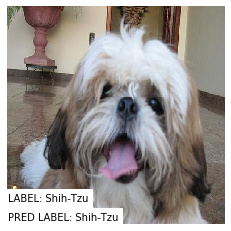

In [234]:
show_image_pred(y_val_indexes[190],pred = valid_preds[190],for_pred=True)

In [204]:
print(classification_report(valid_breeds, valid_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93        58
         1.0       0.97      0.92      0.94        37
         2.0       0.69      0.87      0.77        31
         3.0       0.62      0.58      0.60        31
         4.0       0.59      0.71      0.65        31
         5.0       0.74      0.78      0.76        41
         6.0       1.00      0.97      0.98        30
         7.0       0.84      0.91      0.88        35
         8.0       0.79      0.90      0.84        30
         9.0       0.58      0.64      0.61        28
        10.0       0.89      0.95      0.92        42
        11.0       0.97      0.85      0.91        41
        12.0       0.77      0.83      0.80        29
        13.0       0.91      0.86      0.89        37
        14.0       0.80      0.75      0.77        32
        15.0       0.77      0.83      0.80        29
        16.0       0.90      0.82      0.86        34
        17.0       0.75    

In [605]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (20,20))
    plt.imshow(cm,  cmap=cmap, aspect='auto') #Create the basic matrix.
    
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = cm.max() / 2. #Used for text coloring below

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    return plt.show()

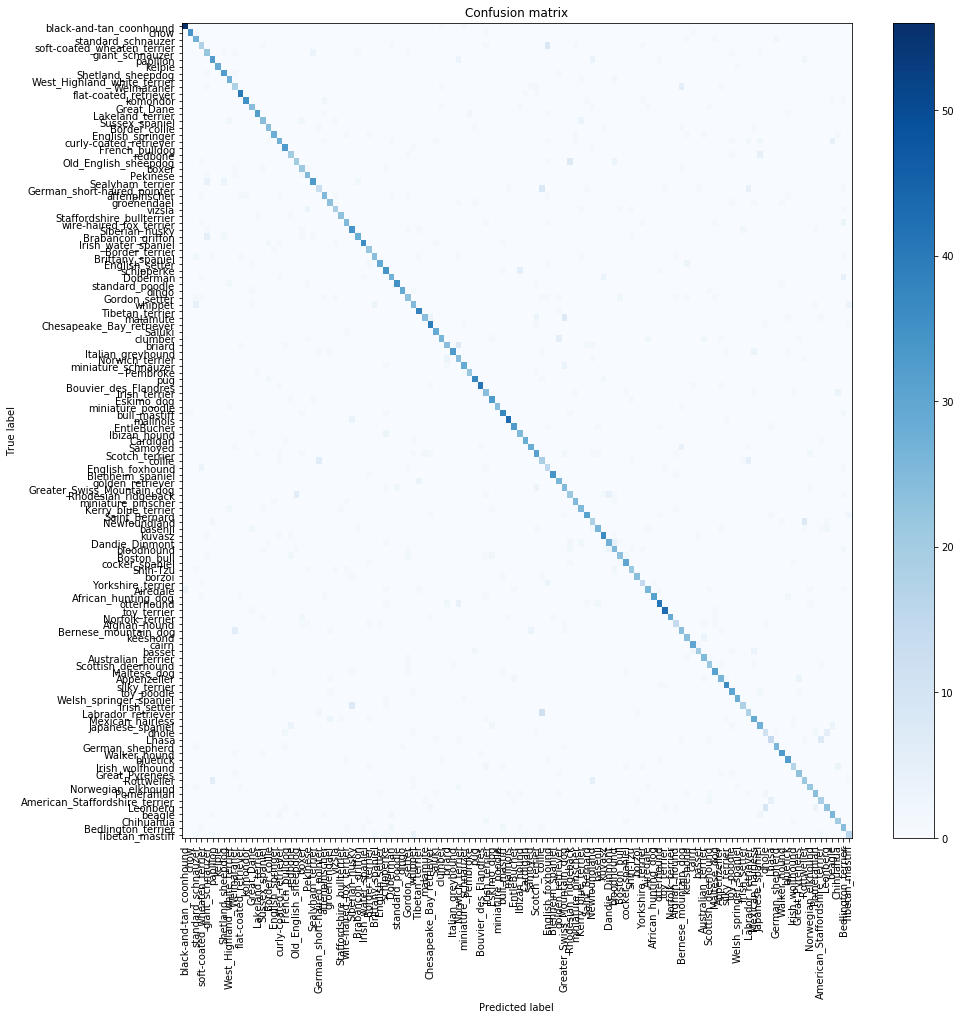

In [206]:
plot_confusion_matrix(confusion_matrix(valid_breeds, valid_preds),list(y_table.columns))

### Random Forest

In [240]:
clf = RandomForestClassifier()

# fitting the model to train set
clf.fit(train_arr, (y_train * range(120)).sum(axis=1))  

# running predictions on validation set - predicting classes and their probabilites
valid_probs = clf.predict_proba(valid_arr)
valid_preds = clf.predict(valid_arr)
print(classification_report(valid_breeds, valid_preds))


print('Validation RN50 LogLoss {}'.format(log_loss(valid_breeds, valid_probs)))
print('Validation RN50 Accuracy {}'.format(accuracy_score(valid_breeds, valid_preds)))

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

         0.0       0.40      0.76      0.53        58
         1.0       0.43      0.86      0.58        37
         2.0       0.30      0.74      0.43        31
         3.0       0.22      0.42      0.29        31
         4.0       0.25      0.32      0.28        31
         5.0       0.33      0.59      0.42        41
         6.0       0.54      0.87      0.67        30
         7.0       0.53      0.89      0.66        35
         8.0       0.54      0.83      0.66        30
         9.0       0.33      0.50      0.40        28
        10.0       0.47      0.67      0.55        42
        11.0       0.64      0.83      0.72        41
        12.0       0.47      0.72      0.57        29
        13.0       0.59      0.70      0.64        37
        14.0       0.46      0.69      0.55        32
        15.0       0.26      0.48      0.34        29
        16.0       0.39      0.41      0.40        34
        17.0       0.36    

Accuracy at the level of 54% seems to be very low, compared to logistic regression. I will try to run grid search to improve this score

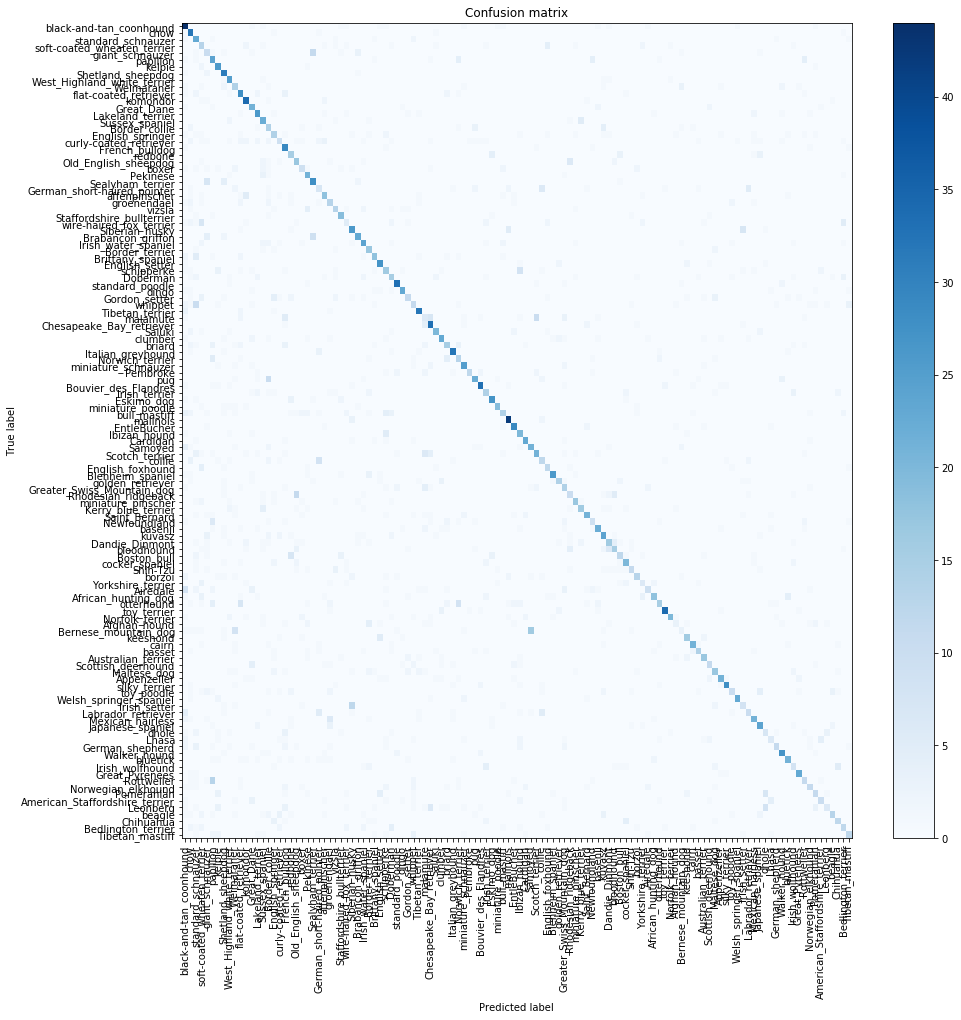

In [241]:
plot_confusion_matrix(confusion_matrix(valid_breeds, valid_preds),list(y_table.columns))

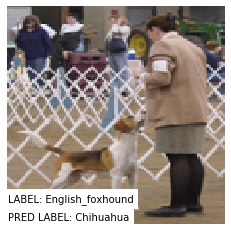

In [246]:
show_image_pred(y_val_indexes[590],pred = valid_preds[590],for_pred=True)

### Random Forest with GridsearchCV

Setting the grid for finding best performing parameters

In [248]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 12, 16, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

In [ ]:
rf_clf = RandomForestClassifier(random_state = 42)
start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, verbose=10)
rf_grid_search.fit(train_arr, (y_train * range(120)).sum(axis=1))

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Total Runtime for Grid Search on Random Forest Classifier: {time.time() - start :.2f} seconds")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Optimal Parameters: criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100

In [281]:
clf_gs = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)
clf_gs.fit(train_arr, (y_train * range(120)).sum(axis=1))  
valid_probs_gs = clf_gs.predict_proba(valid_arr)
valid_preds_gs = clf_gs.predict(valid_arr)
print(classification_report(valid_breeds, valid_preds_gs))
print('Validation RN50 LogLoss {}'.format(log_loss(valid_breeds, valid_probs_gs)))
print('Validation RN50 Accuracy {}'.format(accuracy_score(valid_breeds, valid_preds_gs)))

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88        58
         1.0       0.76      0.95      0.84        37
         2.0       0.55      0.84      0.67        31
         3.0       0.63      0.55      0.59        31
         4.0       0.69      0.35      0.47        31
         5.0       0.68      0.66      0.67        41
         6.0       0.83      1.00      0.91        30
         7.0       0.69      0.97      0.81        35
         8.0       0.77      0.90      0.83        30
         9.0       0.63      0.86      0.73        28
        10.0       0.83      0.93      0.88        42
        11.0       0.76      0.93      0.84        41
        12.0       0.71      0.69      0.70        29
        13.0       0.86      0.84      0.85        37
        14.0       0.67      0.75      0.71        32
        15.0       0.84      0.55      0.67        29
        16.0       0.77      0.68      0.72        34
        17.0       0.69    

Accuracy increased to the level of 73%, but is still lower than logistic regression.

In this project I would like to try using neural networks for classification to see if this will give me better results than simple logistic regression.

## Neural Networks

#### First model - 5 layers, activation - 'relu', last layer classification - 'softmax'

In [262]:
model_1 = Sequential()
model_1.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_1.add(Dense(750, activation = 'relu'))
model_1.add(Dense(500, activation = 'relu'))
model_1.add(Dense(240, activation = 'relu'))
model_1.add(Dense(120, activation = 'softmax'))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_7 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_9 (Dense)              (None, 240)               120240    
_________________________________________________________________
dense_10 (Dense)             (None, 120)               28920     
Total params: 3,324,410
Trainable params: 3,324,410
Non-trainable params: 0
_________________________________________________________________


In [263]:
model_1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
net_1 = model_1.fit(train_arr, y_train, epochs = 100, verbose = 2, batch_size = 64, validation_data = (valid_arr, y_val))

In [269]:
y_train.shape,y_val.shape

((16532, 120), (4048, 120))

In [266]:
score = model_1.evaluate(valid_arr, y_val, batch_size=128)

4048/4048 [==============================] - 0s 118us/step


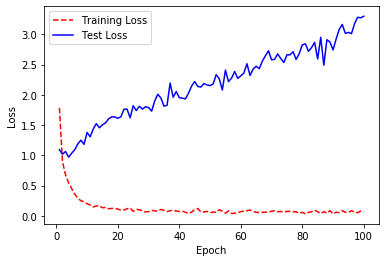

In [267]:
# Get training and test loss histories
training_loss = net_1.history['loss']
test_loss = net_1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

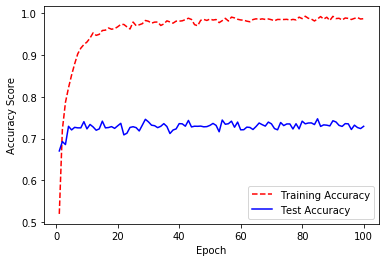

In [270]:
# Get training and test accuracy histories
training_accuracy = net_1.history['accuracy']
test_accuracy = net_1.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

Accuracy at the level of 72%, logloss - increasing

Write helper function for future plotting

In [296]:
def plot_accuracy(model_fit):
    # Get training and test accuracy histories
    training_accuracy = model_fit.history['accuracy']
    test_accuracy = model_fit.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_accuracy) + 1)

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    return plt.show();

In [297]:
def plot_loss(model_fit):
    training_loss = model_fit.history['loss']
    test_loss = model_fit.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return plt.show();

#### Second model - 7 layers, activation - 'relu', last layer classification - 'softmax', adding regularization by 0.25 dropout layers

In [272]:
model_2 = Sequential()
model_2.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_2.add(Dropout(0.25))
model_2.add(Dense(750, activation = 'relu'))
model_2.add(Dense(500, activation = 'relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(240, activation = 'relu'))
model_2.add(Dense(120, activation = 'softmax'))
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 750)               750750    
_________________________________________________________________
dense_14 (Dense)             (None, 500)               375500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_16 (Dense)             (None, 120)              

In [274]:
model_2.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [277]:
net_2 = model_2.fit(train_arr, y_train, epochs = 10, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/10


 - 18s - loss: 0.1751 - accuracy: 0.9492 - val_loss: 1.4345 - val_accuracy: 0.7406
Epoch 2/10


 - 18s - loss: 0.1736 - accuracy: 0.9497 - val_loss: 1.4371 - val_accuracy: 0.7468
Epoch 3/10


 - 16s - loss: 0.1829 - accuracy: 0.9514 - val_loss: 1.4425 - val_accuracy: 0.7490
Epoch 4/10


 - 16s - loss: 0.1783 - accuracy: 0.9496 - val_loss: 1.4471 - val_accuracy: 0.7458
Epoch 5/10


 - 17s - loss: 0.1662 - accuracy: 0.9557 - val_loss: 1.5302 - val_accuracy: 0.7339
Epoch 6/10


 - 15s - loss: 0.1532 - accuracy: 0.9578 - val_loss: 1.4285 - val_accuracy: 0.7510
Epoch 7/10


 - 20s - loss: 0.1390 - accuracy: 0.9609 - val_loss: 1.4223 - val_accuracy: 0.7488
Epoch 8/10


 - 19s - loss: 0.1591 - accuracy: 0.9581 - val_loss: 1.3864 - val_accuracy: 0.7549
Epoch 9/10


 - 16s - loss: 0.1398 - accuracy: 0.9601 - val_loss: 1.3712 - val_accuracy: 0.7626
Epoch 10/10


 - 19s - loss: 0.1377 - accuracy: 0.9615 - val_loss: 1.5338 - val_accuracy: 0.7485


Validation loss is going up and validation accuracy is at the level of 75%

#### Model 3 - 4 layers, activation - 'relu', last layer classification - 'softmax', adding regularization by one 0.25 dropout layer

In [289]:
model_3 = Sequential()
model_3.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_3.add(Dropout(0.25))
model_3.add(Dense(240, activation = 'relu'))
model_3.add(Dense(120, activation = 'softmax'))
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 240)               240240    
_________________________________________________________________
dense_22 (Dense)             (None, 120)               28920     
Total params: 2,318,160
Trainable params: 2,318,160
Non-trainable params: 0
_________________________________________________________________


In [290]:
model_3.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
net_3 = model_3.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64, callbacks = [TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

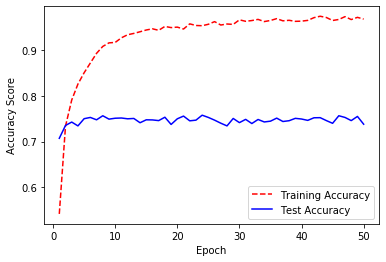

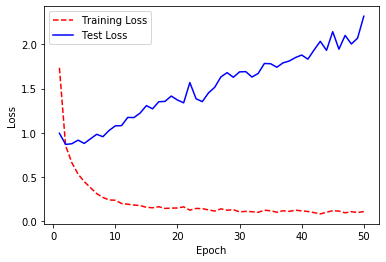

(None, None)

In [295]:
plot_accuracy(net_3), plot_loss(net_3)

Accuracy at the level of 74%, logloss increasing

#### Model 4 - 7 layers, activation - 'tanh', last layer classification - 'softmax', adding regularization by 0.25 dropout layers

In [298]:
model_4 = Sequential()
model_4.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_4.add(Dropout(0.25))
model_4.add(Dense(750, activation = 'tanh'))
model_4.add(Dense(500, activation = 'tanh'))
model_4.add(Dropout(0.25))
model_4.add(Dense(240, activation = 'tanh'))
model_4.add(Dense(120, activation = 'softmax'))
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 750)               750750    
_________________________________________________________________
dense_25 (Dense)             (None, 500)               375500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_27 (Dense)             (None, 120)              

In [299]:
model_4.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
net_4 = model_4.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64, callbacks = [TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

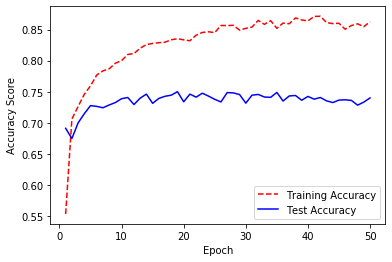

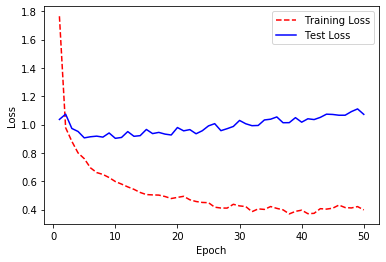

(None, None)

In [302]:
plot_accuracy(net_4), plot_loss(net_4)

Accuracy at the level of 73.5%, logloss slightly increasing

#### Model 5 - 7 layers, activation - 'relu', last layer classification - 'softmax', adding regularization by 0.25 dropout layers and initialization by random uniform distribution

In [311]:
model_5 = Sequential()
model_5.add(Dense(1000, activation = 'relu',  kernel_initializer='random_uniform',
                bias_initializer='zeros', input_shape = train_arr[0].shape))
model_5.add(Dropout(0.25))
model_5.add(Dense(750, activation = 'relu'))
model_5.add(Dense(500, activation = 'relu'))
model_5.add(Dropout(0.25))
model_5.add(Dense(240, activation = 'relu'))
model_5.add(Dense(120, activation = 'softmax'))
model_5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 750)               750750    
_________________________________________________________________
dense_40 (Dense)             (None, 500)               375500    
_________________________________________________________________
dropout_12 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_42 (Dense)             (None, 120)             

In [312]:
model_5.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [313]:
net_5 = model_5.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 20s - loss: 2.1911 - accuracy: 0.4296 - val_loss: 1.1255 - val_accuracy: 0.6581
Epoch 2/50


 - 17s - loss: 1.1365 - accuracy: 0.6553 - val_loss: 0.9825 - val_accuracy: 0.6994
Epoch 3/50


 - 17s - loss: 0.9342 - accuracy: 0.7116 - val_loss: 0.9584 - val_accuracy: 0.7144
Epoch 4/50


 - 17s - loss: 0.8050 - accuracy: 0.7450 - val_loss: 0.9869 - val_accuracy: 0.7083
Epoch 5/50


 - 17s - loss: 0.7309 - accuracy: 0.7716 - val_loss: 0.9305 - val_accuracy: 0.7320
Epoch 6/50


 - 17s - loss: 0.6241 - accuracy: 0.8008 - val_loss: 0.9297 - val_accuracy: 0.7359
Epoch 7/50


 - 17s - loss: 0.5721 - accuracy: 0.8143 - val_loss: 0.9597 - val_accuracy: 0.7305
Epoch 8/50


 - 17s - loss: 0.5117 - accuracy: 0.8343 - val_loss: 0.9565 - val_accuracy: 0.7453
Epoch 9/50


 - 17s - loss: 0.4921 - accuracy: 0.8395 - val_loss: 1.0428 - val_accuracy: 0.7297
Epoch 10/50


 - 18s - loss: 0.4480 - accuracy: 0.8537 - val_loss: 1.0375 - val_accuracy: 0.7357
Epoch 11/50


 - 17s - loss: 0.3982 - accuracy: 0.8712 - val_loss: 1.0864 - val_accuracy: 0.7325


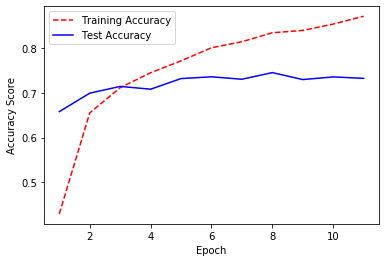

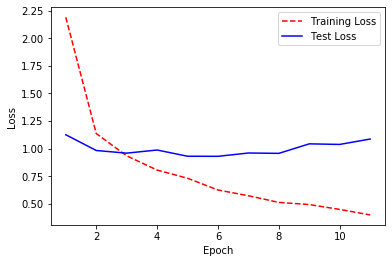

(None, None)

In [314]:
plot_accuracy(net_5), plot_loss(net_5)

Accuracy at the level of 73%

#### Model 6 - 7 layers, increase of nodes number

In [315]:
model_6 = Sequential()
model_6.add(Dense(2048, activation = 'relu',  kernel_initializer='random_uniform',
                bias_initializer='zeros', input_shape = train_arr[0].shape))
model_6.add(Dense(1024, activation = 'relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(500, activation = 'relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(240, activation = 'relu'))
model_6.add(Dense(120, activation = 'softmax'))
model_6.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 500)               512500    
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_47 (Dense)             (None, 120)             

In [316]:
model_6.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [317]:
net_6 = model_6.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 37s - loss: 2.3334 - accuracy: 0.4010 - val_loss: 1.1247 - val_accuracy: 0.6630
Epoch 2/50


 - 36s - loss: 1.1030 - accuracy: 0.6657 - val_loss: 1.0224 - val_accuracy: 0.7011
Epoch 3/50


 - 36s - loss: 0.8644 - accuracy: 0.7351 - val_loss: 1.0127 - val_accuracy: 0.7021
Epoch 4/50


 - 36s - loss: 0.7241 - accuracy: 0.7747 - val_loss: 0.9893 - val_accuracy: 0.7191
Epoch 5/50


 - 38s - loss: 0.6007 - accuracy: 0.8098 - val_loss: 0.9719 - val_accuracy: 0.7320
Epoch 6/50


 - 40s - loss: 0.5072 - accuracy: 0.8389 - val_loss: 1.0217 - val_accuracy: 0.7290
Epoch 7/50


 - 39s - loss: 0.4242 - accuracy: 0.8618 - val_loss: 0.9963 - val_accuracy: 0.7431
Epoch 8/50


 - 37s - loss: 0.3726 - accuracy: 0.8788 - val_loss: 1.0517 - val_accuracy: 0.7285
Epoch 9/50


 - 35s - loss: 0.3349 - accuracy: 0.8897 - val_loss: 1.1318 - val_accuracy: 0.7362
Epoch 10/50


 - 37s - loss: 0.2922 - accuracy: 0.9065 - val_loss: 1.2471 - val_accuracy: 0.7322


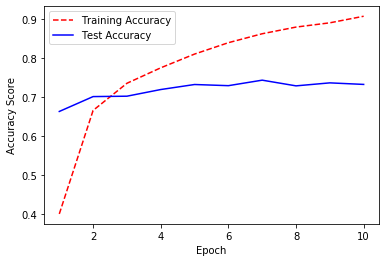

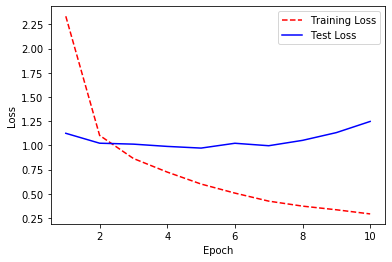

(None, None)

In [318]:
plot_accuracy(net_6), plot_loss(net_6)

Accuracy at the level of 73%

#### Model 7 - 11 layers, increase of nodes number, activation - 'relu', adding initializers at each dense layer

In [323]:
model_7 = Sequential()
model_7.add(Dense(2048, activation = 'relu',  kernel_initializer='random_uniform',
             bias_initializer='zeros', input_shape = train_arr[0].shape))
model_7.add(Dense(1024,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dropout(0.25))
model_7.add(Dense(500,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dense(1024,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dropout(0.25))
model_7.add(Dense(1024,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dense(500,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dropout(0.25))
model_7.add(Dense(240,kernel_initializer='random_uniform',
             bias_initializer='zeros', activation = 'relu'))
model_7.add(Dense(120, activation = 'softmax'))
model_7.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_57 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              513024    
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)            

In [324]:
model_7.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [325]:
net_7 = model_7.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 54s - loss: 3.7427 - accuracy: 0.0831 - val_loss: 2.8342 - val_accuracy: 0.1892
Epoch 2/50


 - 59s - loss: 2.2443 - accuracy: 0.3210 - val_loss: 1.8456 - val_accuracy: 0.4177
Epoch 3/50


 - 53s - loss: 1.6401 - accuracy: 0.4779 - val_loss: 1.5193 - val_accuracy: 0.5390
Epoch 4/50


 - 69s - loss: 1.2816 - accuracy: 0.5858 - val_loss: 1.3548 - val_accuracy: 0.6060
Epoch 5/50


 - 56s - loss: 1.0786 - accuracy: 0.6538 - val_loss: 1.2830 - val_accuracy: 0.6213
Epoch 6/50


 - 50s - loss: 0.9424 - accuracy: 0.6960 - val_loss: 1.3179 - val_accuracy: 0.6480
Epoch 7/50


 - 53s - loss: 0.8289 - accuracy: 0.7394 - val_loss: 1.1992 - val_accuracy: 0.6719
Epoch 8/50


 - 50s - loss: 0.7252 - accuracy: 0.7669 - val_loss: 1.2281 - val_accuracy: 0.6890
Epoch 9/50


 - 52s - loss: 0.6567 - accuracy: 0.7942 - val_loss: 1.2559 - val_accuracy: 0.6897
Epoch 10/50


 - 47s - loss: 0.6065 - accuracy: 0.8092 - val_loss: 1.2926 - val_accuracy: 0.7028
Epoch 11/50


 - 47s - loss: 0.5685 - accuracy: 0.8242 - val_loss: 1.3125 - val_accuracy: 0.6947
Epoch 12/50


 - 48s - loss: 0.5243 - accuracy: 0.8404 - val_loss: 1.3361 - val_accuracy: 0.7107


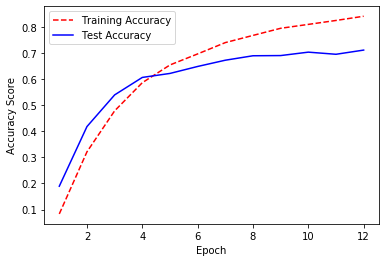

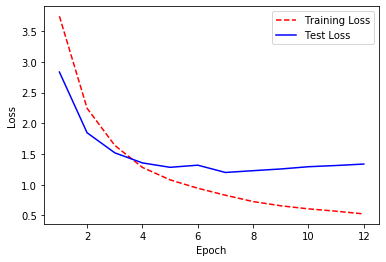

(None, None)

In [326]:
plot_accuracy(net_7), plot_loss(net_7)

Accuracy at the level of 70%, but log loss is going down

#### Model 8 - 7 layers, increase of nodes number, activation - 'relu', cone shape

In [327]:
model_8 = Sequential()
model_8.add(Dense(2048, activation = 'relu', input_shape = train_arr[0].shape))
model_8.add(Dense(4096, activation = 'relu'))
model_8.add(Dense(2048, activation = 'relu'))
model_8.add(Dense(1024, activation = 'relu'))
model_8.add(Dense(500, activation = 'relu'))
model_8.add(Dense(240, activation = 'relu'))
model_8.add(Dense(120, activation = 'softmax'))
model_8.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_65 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_66 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_67 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_68 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_69 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_70 (Dense)             (None, 120)             

In [328]:
model_8.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [329]:
net_8 = model_8.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 124s - loss: 2.6341 - accuracy: 0.3183 - val_loss: 1.5876 - val_accuracy: 0.5235
Epoch 2/50


 - 119s - loss: 1.2812 - accuracy: 0.6095 - val_loss: 1.3247 - val_accuracy: 0.6129
Epoch 3/50


 - 120s - loss: 0.9945 - accuracy: 0.6930 - val_loss: 1.3178 - val_accuracy: 0.6312
Epoch 4/50


 - 117s - loss: 0.8072 - accuracy: 0.7465 - val_loss: 1.1254 - val_accuracy: 0.6806
Epoch 5/50


 - 121s - loss: 0.6926 - accuracy: 0.7822 - val_loss: 1.2411 - val_accuracy: 0.6868
Epoch 6/50


 - 119s - loss: 0.6163 - accuracy: 0.8057 - val_loss: 1.1424 - val_accuracy: 0.7058
Epoch 7/50


 - 117s - loss: 0.5286 - accuracy: 0.8320 - val_loss: 1.2260 - val_accuracy: 0.6919
Epoch 8/50


 - 116s - loss: 0.4653 - accuracy: 0.8517 - val_loss: 1.2432 - val_accuracy: 0.7105
Epoch 9/50


 - 118s - loss: 0.4465 - accuracy: 0.8602 - val_loss: 1.2818 - val_accuracy: 0.7036


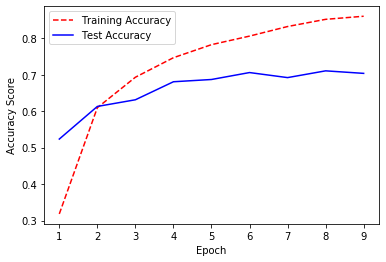

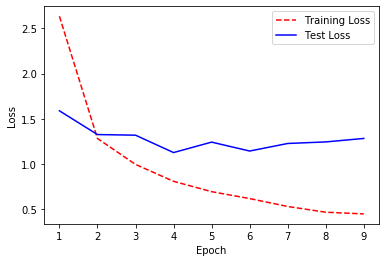

(None, None)

In [331]:
plot_accuracy(net_8), plot_loss(net_8)

Accuracy - 70%

#### Model 9 - 5 layers, increase of nodes number, activation - 'relu', adding l2 regularization

In [335]:
model_9 = Sequential()
model_9.add(Dense(2048, activation = 'relu', input_shape = train_arr[0].shape))
model_9.add(Dense(1024, activation = 'relu'))
model_9.add(Dense(500, activation = 'relu'))
model_9.add(Dense(240, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model_9.add(Dense(120, activation = 'softmax'))
model_9.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_84 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_85 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_86 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_87 (Dense)             (None, 120)               28920     
Total params: 6,956,188
Trainable params: 6,956,188
Non-trainable params: 0
_________________________________________________________________


In [336]:
model_9.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [337]:
net_9 = model_9.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 42s - loss: 2.7600 - accuracy: 0.5102 - val_loss: 1.6279 - val_accuracy: 0.6482
Epoch 2/50


 - 41s - loss: 1.2657 - accuracy: 0.7165 - val_loss: 1.2645 - val_accuracy: 0.7201
Epoch 3/50


 - 39s - loss: 0.9483 - accuracy: 0.7750 - val_loss: 1.1944 - val_accuracy: 0.7068
Epoch 4/50


 - 39s - loss: 0.7389 - accuracy: 0.8177 - val_loss: 1.0993 - val_accuracy: 0.7305
Epoch 5/50


 - 39s - loss: 0.5851 - accuracy: 0.8566 - val_loss: 1.1394 - val_accuracy: 0.7248
Epoch 6/50


 - 40s - loss: 0.4820 - accuracy: 0.8781 - val_loss: 1.1883 - val_accuracy: 0.7228
Epoch 7/50


 - 38s - loss: 0.4240 - accuracy: 0.8951 - val_loss: 1.2291 - val_accuracy: 0.7204
Epoch 8/50


 - 38s - loss: 0.3393 - accuracy: 0.9210 - val_loss: 1.2419 - val_accuracy: 0.7325
Epoch 9/50


 - 37s - loss: 0.3100 - accuracy: 0.9261 - val_loss: 1.2754 - val_accuracy: 0.7451


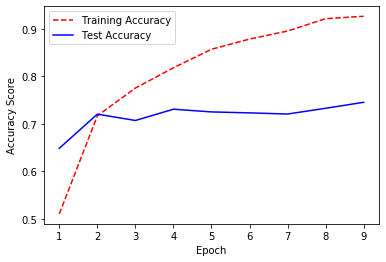

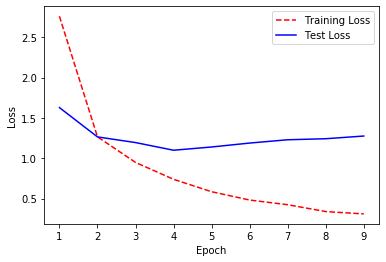

(None, None)

In [338]:
plot_accuracy(net_9), plot_loss(net_9)

Accuracy went up to 74% but log loss is going up

#### Model 10 - 5 layers, increase of nodes number, activation - 'tanh', adding l2 regularization

In [340]:
model_10 = Sequential()
model_10.add(Dense(2048, activation = 'tanh', input_shape = train_arr[0].shape))
model_10.add(Dense(1024, activation = 'tanh'))
model_10.add(Dense(500, activation = 'tanh'))
model_10.add(Dense(240, kernel_regularizer=regularizers.l2(0.01), activation = 'tanh'))
model_10.add(Dense(120, activation = 'softmax'))
model_10.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_95 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_96 (Dense)             (None, 240)               120240    
_________________________________________________________________
dense_97 (Dense)             (None, 120)               28920     
Total params: 6,956,188
Trainable params: 6,956,188
Non-trainable params: 0
_________________________________________________________________


In [341]:
model_10.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [342]:
net_10 = model_10.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 43s - loss: 2.9885 - accuracy: 0.5879 - val_loss: 1.5361 - val_accuracy: 0.6769
Epoch 2/50


 - 39s - loss: 1.1912 - accuracy: 0.7326 - val_loss: 1.2126 - val_accuracy: 0.7095
Epoch 3/50


 - 40s - loss: 0.9518 - accuracy: 0.7680 - val_loss: 1.1647 - val_accuracy: 0.7021
Epoch 4/50


 - 40s - loss: 0.8501 - accuracy: 0.7932 - val_loss: 1.1144 - val_accuracy: 0.7228
Epoch 5/50


 - 40s - loss: 0.7870 - accuracy: 0.8034 - val_loss: 1.1130 - val_accuracy: 0.7201
Epoch 6/50


 - 40s - loss: 0.7416 - accuracy: 0.8160 - val_loss: 1.1942 - val_accuracy: 0.7050
Epoch 7/50


 - 39s - loss: 0.7127 - accuracy: 0.8207 - val_loss: 1.1634 - val_accuracy: 0.7129
Epoch 8/50


 - 48s - loss: 0.6925 - accuracy: 0.8266 - val_loss: 1.1718 - val_accuracy: 0.7152
Epoch 9/50


 - 43s - loss: 0.6692 - accuracy: 0.8332 - val_loss: 1.1478 - val_accuracy: 0.7201
Epoch 10/50


 - 37s - loss: 0.6470 - accuracy: 0.8415 - val_loss: 1.1840 - val_accuracy: 0.7117


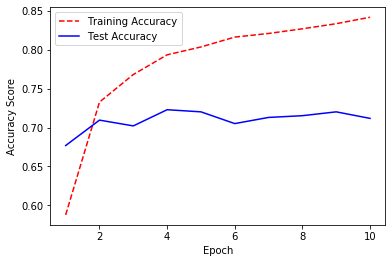

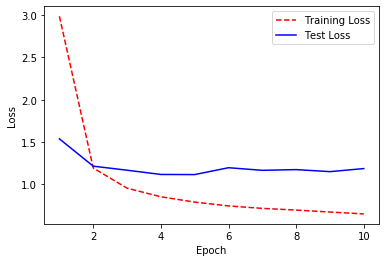

(None, None)

In [343]:
plot_accuracy(net_10), plot_loss(net_10)

With tanh accuracy decreased to 72%

#### Model 11 - starting over from model 2 - model 2a - 8 layers, one layer added

In [345]:
model_2a = Sequential()
model_2a.add(Dense(2048, activation = 'relu', input_shape = train_arr[0].shape))
model_2a.add(Dense(1000, activation = 'relu'))
model_2a.add(Dropout(0.25))
model_2a.add(Dense(750, activation = 'relu'))
model_2a.add(Dense(500, activation = 'relu'))
model_2a.add(Dropout(0.25))
model_2a.add(Dense(240, activation = 'relu'))
model_2a.add(Dense(120, activation = 'softmax'))
model_2a.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dense_104 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_106 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_24 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 240)             

In [346]:
model_2a.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [347]:
net_2a = model_2a.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64,callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 44s - loss: 2.4557 - accuracy: 0.3647 - val_loss: 1.3191 - val_accuracy: 0.6010
Epoch 2/50


 - 44s - loss: 1.2119 - accuracy: 0.6325 - val_loss: 1.0960 - val_accuracy: 0.6742
Epoch 3/50


 - 44s - loss: 0.9895 - accuracy: 0.7009 - val_loss: 1.0705 - val_accuracy: 0.6902
Epoch 4/50


 - 44s - loss: 0.8096 - accuracy: 0.7463 - val_loss: 0.9582 - val_accuracy: 0.7211
Epoch 5/50


 - 48s - loss: 0.6756 - accuracy: 0.7891 - val_loss: 1.0481 - val_accuracy: 0.7127
Epoch 6/50


 - 49s - loss: 0.6010 - accuracy: 0.8092 - val_loss: 1.0616 - val_accuracy: 0.7196
Epoch 7/50


 - 43s - loss: 0.5259 - accuracy: 0.8360 - val_loss: 0.9984 - val_accuracy: 0.7337
Epoch 8/50


 - 46s - loss: 0.4595 - accuracy: 0.8546 - val_loss: 1.1561 - val_accuracy: 0.7184
Epoch 9/50


 - 48s - loss: 0.4300 - accuracy: 0.8650 - val_loss: 1.2384 - val_accuracy: 0.7174


Accuracy 72%, log loss going up

#### Model 12 - starting over from model 2 - model 2b - rerun of model 2

In [348]:
model_2b = Sequential()
model_2b.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_2b.add(Dropout(0.25))
model_2b.add(Dense(750, activation = 'relu'))
model_2b.add(Dense(500, activation = 'relu'))
model_2b.add(Dropout(0.25))
model_2b.add(Dense(240, activation = 'relu'))
model_2b.add(Dense(120, activation = 'softmax'))
model_2b.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_111 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_26 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_113 (Dense)            (None, 120)             

In [349]:
model_2b.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
net_2b = model_2b.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

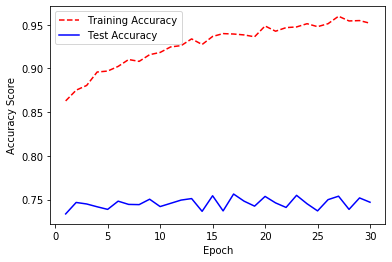

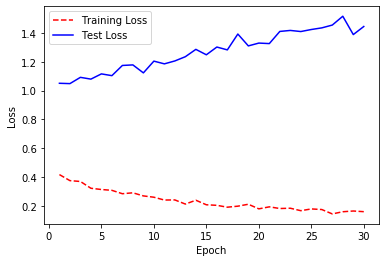

(None, None)

In [352]:
plot_accuracy(net_2b), plot_loss(net_2b)

#### Model 13 - model 2c - change of optimizer

In [353]:
model_2c = Sequential()
model_2c.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_2c.add(Dropout(0.25))
model_2c.add(Dense(750, activation = 'relu'))
model_2c.add(Dense(500, activation = 'relu'))
model_2c.add(Dropout(0.25))
model_2c.add(Dense(240, activation = 'relu'))
model_2c.add(Dense(120, activation = 'softmax'))
model_2c.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_27 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_115 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_116 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_28 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_118 (Dense)            (None, 120)             

In [355]:
model_2c.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [356]:
net_2c = model_2c.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 11s - loss: 4.5457 - accuracy: 0.0579 - val_loss: 3.8377 - val_accuracy: 0.2315
Epoch 2/30


 - 12s - loss: 2.9977 - accuracy: 0.2864 - val_loss: 1.8428 - val_accuracy: 0.5027
Epoch 3/30


 - 14s - loss: 1.7316 - accuracy: 0.5175 - val_loss: 1.1837 - val_accuracy: 0.6539
Epoch 4/30


 - 13s - loss: 1.3110 - accuracy: 0.6118 - val_loss: 1.0501 - val_accuracy: 0.6890
Epoch 5/30


 - 12s - loss: 1.1131 - accuracy: 0.6595 - val_loss: 0.9372 - val_accuracy: 0.7125
Epoch 6/30


 - 11s - loss: 0.9964 - accuracy: 0.6913 - val_loss: 0.9112 - val_accuracy: 0.7169
Epoch 7/30


 - 15s - loss: 0.9153 - accuracy: 0.7153 - val_loss: 0.8745 - val_accuracy: 0.7233
Epoch 8/30


 - 15s - loss: 0.8458 - accuracy: 0.7350 - val_loss: 0.8208 - val_accuracy: 0.7448
Epoch 9/30


 - 13s - loss: 0.7910 - accuracy: 0.7499 - val_loss: 0.8203 - val_accuracy: 0.7470
Epoch 10/30


 - 12s - loss: 0.7494 - accuracy: 0.7571 - val_loss: 0.8027 - val_accuracy: 0.7488
Epoch 11/30


 - 13s - loss: 0.7094 - accuracy: 0.7746 - val_loss: 0.7987 - val_accuracy: 0.7512
Epoch 12/30


 - 12s - loss: 0.6659 - accuracy: 0.7870 - val_loss: 0.7675 - val_accuracy: 0.7569
Epoch 13/30


 - 12s - loss: 0.6471 - accuracy: 0.7931 - val_loss: 0.7789 - val_accuracy: 0.7624
Epoch 14/30


 - 13s - loss: 0.6109 - accuracy: 0.8026 - val_loss: 0.7521 - val_accuracy: 0.7708
Epoch 15/30


 - 11s - loss: 0.5767 - accuracy: 0.8122 - val_loss: 0.7482 - val_accuracy: 0.7656
Epoch 16/30


 - 13s - loss: 0.5586 - accuracy: 0.8216 - val_loss: 0.7571 - val_accuracy: 0.7666
Epoch 17/30


 - 13s - loss: 0.5408 - accuracy: 0.8245 - val_loss: 0.7326 - val_accuracy: 0.7717
Epoch 18/30


 - 12s - loss: 0.5104 - accuracy: 0.8338 - val_loss: 0.7445 - val_accuracy: 0.7703
Epoch 19/30


 - 13s - loss: 0.4893 - accuracy: 0.8413 - val_loss: 0.7540 - val_accuracy: 0.7693
Epoch 20/30


 - 11s - loss: 0.4688 - accuracy: 0.8460 - val_loss: 0.7595 - val_accuracy: 0.7700
Epoch 21/30


 - 13s - loss: 0.4503 - accuracy: 0.8526 - val_loss: 0.7602 - val_accuracy: 0.7715
Epoch 22/30


 - 13s - loss: 0.4349 - accuracy: 0.8568 - val_loss: 0.7436 - val_accuracy: 0.7754
Epoch 23/30


 - 12s - loss: 0.4117 - accuracy: 0.8644 - val_loss: 0.7553 - val_accuracy: 0.7730
Epoch 24/30


 - 14s - loss: 0.4010 - accuracy: 0.8707 - val_loss: 0.7606 - val_accuracy: 0.7779
Epoch 25/30


 - 13s - loss: 0.3820 - accuracy: 0.8722 - val_loss: 0.7566 - val_accuracy: 0.7747
Epoch 26/30


 - 12s - loss: 0.3673 - accuracy: 0.8791 - val_loss: 0.7745 - val_accuracy: 0.7750
Epoch 27/30


 - 12s - loss: 0.3529 - accuracy: 0.8848 - val_loss: 0.7634 - val_accuracy: 0.7792
Epoch 28/30


 - 12s - loss: 0.3368 - accuracy: 0.8896 - val_loss: 0.7526 - val_accuracy: 0.7816
Epoch 29/30


 - 12s - loss: 0.3242 - accuracy: 0.8934 - val_loss: 0.7654 - val_accuracy: 0.7767
Epoch 30/30


 - 11s - loss: 0.3183 - accuracy: 0.8953 - val_loss: 0.7563 - val_accuracy: 0.7754


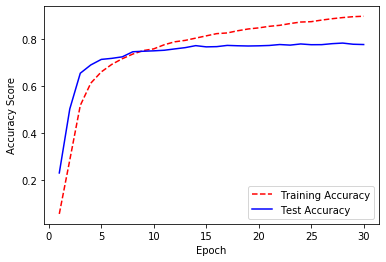

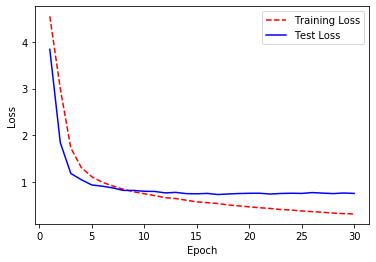

(None, None)

In [357]:
plot_accuracy(net_2c), plot_loss(net_2c)

Model accuracy went over 77%, logloss going down below 1

#### Model 14 - model 2d - starting from model 2c with glorot-normal initializer

In [358]:
model_2d = Sequential()
model_2d.add(Dense(1000, activation = 'relu',kernel_initializer='glorot_normal', input_shape = train_arr[0].shape))
model_2d.add(Dropout(0.25))
model_2d.add(Dense(750, activation = 'relu'))
model_2d.add(Dense(500, activation = 'relu'))
model_2d.add(Dropout(0.25))
model_2d.add(Dense(240, activation = 'relu'))
model_2d.add(Dense(120, activation = 'softmax'))
model_2d.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_121 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_123 (Dense)            (None, 120)             

In [359]:
model_2d.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [360]:
net_2d = model_2d.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 14s - loss: 4.5580 - accuracy: 0.0567 - val_loss: 3.8630 - val_accuracy: 0.2490
Epoch 2/30


 - 11s - loss: 2.9819 - accuracy: 0.2940 - val_loss: 1.6925 - val_accuracy: 0.5581
Epoch 3/30


 - 10s - loss: 1.6826 - accuracy: 0.5241 - val_loss: 1.1814 - val_accuracy: 0.6539
Epoch 4/30


 - 11s - loss: 1.2842 - accuracy: 0.6191 - val_loss: 0.9917 - val_accuracy: 0.7008
Epoch 5/30


 - 13s - loss: 1.0947 - accuracy: 0.6720 - val_loss: 0.9060 - val_accuracy: 0.7221
Epoch 6/30


 - 12s - loss: 0.9970 - accuracy: 0.6928 - val_loss: 0.8533 - val_accuracy: 0.7327
Epoch 7/30


 - 11s - loss: 0.9033 - accuracy: 0.7188 - val_loss: 0.8311 - val_accuracy: 0.7456
Epoch 8/30


 - 10s - loss: 0.8496 - accuracy: 0.7334 - val_loss: 0.8245 - val_accuracy: 0.7473
Epoch 9/30


 - 12s - loss: 0.7991 - accuracy: 0.7481 - val_loss: 0.7930 - val_accuracy: 0.7520
Epoch 10/30


 - 14s - loss: 0.7551 - accuracy: 0.7600 - val_loss: 0.8017 - val_accuracy: 0.7512
Epoch 11/30


 - 12s - loss: 0.7067 - accuracy: 0.7777 - val_loss: 0.7791 - val_accuracy: 0.7584
Epoch 12/30


 - 12s - loss: 0.6763 - accuracy: 0.7819 - val_loss: 0.7585 - val_accuracy: 0.7609
Epoch 13/30


 - 11s - loss: 0.6384 - accuracy: 0.7969 - val_loss: 0.7684 - val_accuracy: 0.7591
Epoch 14/30


 - 12s - loss: 0.6187 - accuracy: 0.8011 - val_loss: 0.7637 - val_accuracy: 0.7638
Epoch 15/30


 - 12s - loss: 0.5870 - accuracy: 0.8092 - val_loss: 0.7458 - val_accuracy: 0.7690
Epoch 16/30


 - 12s - loss: 0.5655 - accuracy: 0.8158 - val_loss: 0.7329 - val_accuracy: 0.7735
Epoch 17/30


 - 12s - loss: 0.5450 - accuracy: 0.8235 - val_loss: 0.7478 - val_accuracy: 0.7732
Epoch 18/30


 - 12s - loss: 0.5159 - accuracy: 0.8313 - val_loss: 0.7198 - val_accuracy: 0.7836
Epoch 19/30


 - 13s - loss: 0.4954 - accuracy: 0.8386 - val_loss: 0.7385 - val_accuracy: 0.7796
Epoch 20/30


 - 12s - loss: 0.4775 - accuracy: 0.8427 - val_loss: 0.7317 - val_accuracy: 0.7742
Epoch 21/30


 - 12s - loss: 0.4547 - accuracy: 0.8505 - val_loss: 0.7252 - val_accuracy: 0.7833
Epoch 22/30


 - 12s - loss: 0.4395 - accuracy: 0.8577 - val_loss: 0.7536 - val_accuracy: 0.7779
Epoch 23/30


 - 11s - loss: 0.4185 - accuracy: 0.8653 - val_loss: 0.7331 - val_accuracy: 0.7772
Epoch 24/30


 - 12s - loss: 0.4080 - accuracy: 0.8638 - val_loss: 0.7346 - val_accuracy: 0.7848
Epoch 25/30


 - 12s - loss: 0.3870 - accuracy: 0.8747 - val_loss: 0.7191 - val_accuracy: 0.7903
Epoch 26/30


 - 12s - loss: 0.3698 - accuracy: 0.8798 - val_loss: 0.7245 - val_accuracy: 0.7888
Epoch 27/30


 - 12s - loss: 0.3665 - accuracy: 0.8787 - val_loss: 0.7506 - val_accuracy: 0.7789
Epoch 28/30


 - 12s - loss: 0.3481 - accuracy: 0.8835 - val_loss: 0.7522 - val_accuracy: 0.7796
Epoch 29/30


 - 14s - loss: 0.3355 - accuracy: 0.8895 - val_loss: 0.7307 - val_accuracy: 0.7888
Epoch 30/30


 - 13s - loss: 0.3205 - accuracy: 0.8955 - val_loss: 0.7394 - val_accuracy: 0.7848


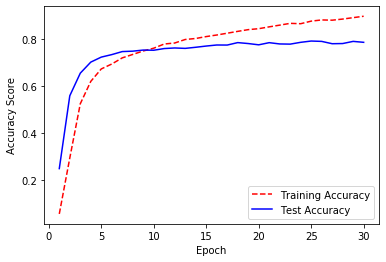

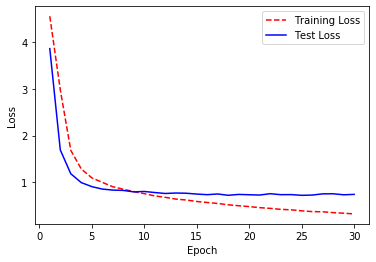

(None, None)

In [361]:
plot_accuracy(net_2d), plot_loss(net_2d)

Accuracy over 78%

#### Model 15 - model 2e - adding initializers to all dense layers

In [362]:
model_2e = Sequential()
model_2e.add(Dense(1000, activation = 'relu',kernel_initializer='glorot_normal', input_shape = train_arr[0].shape))
model_2e.add(Dropout(0.25))
model_2e.add(Dense(750,kernel_initializer='glorot_normal', activation = 'relu'))
model_2e.add(Dense(500,kernel_initializer='glorot_normal', activation = 'relu'))
model_2e.add(Dropout(0.25))
model_2e.add(Dense(240,kernel_initializer='glorot_normal', activation = 'relu'))
model_2e.add(Dense(120, activation = 'softmax'))
model_2e.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_125 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_126 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_32 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_128 (Dense)            (None, 120)             

In [363]:
model_2e.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [364]:
net_2e = model_2e.fit(train_arr, y_train, epochs = 20, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/20


 - 13s - loss: 4.6027 - accuracy: 0.0541 - val_loss: 4.0416 - val_accuracy: 0.2058
Epoch 2/20


 - 11s - loss: 3.1594 - accuracy: 0.2694 - val_loss: 1.8659 - val_accuracy: 0.5222
Epoch 3/20


 - 11s - loss: 1.7670 - accuracy: 0.5033 - val_loss: 1.3055 - val_accuracy: 0.6233
Epoch 4/20


 - 12s - loss: 1.3271 - accuracy: 0.6058 - val_loss: 1.0332 - val_accuracy: 0.6959
Epoch 5/20


 - 12s - loss: 1.1327 - accuracy: 0.6571 - val_loss: 0.9521 - val_accuracy: 0.7110
Epoch 6/20


 - 12s - loss: 1.0027 - accuracy: 0.6924 - val_loss: 0.8966 - val_accuracy: 0.7236
Epoch 7/20


 - 11s - loss: 0.9251 - accuracy: 0.7161 - val_loss: 0.8748 - val_accuracy: 0.7305
Epoch 8/20


 - 11s - loss: 0.8594 - accuracy: 0.7338 - val_loss: 0.8360 - val_accuracy: 0.7448
Epoch 9/20


 - 12s - loss: 0.8109 - accuracy: 0.7424 - val_loss: 0.8216 - val_accuracy: 0.7396
Epoch 10/20


 - 12s - loss: 0.7631 - accuracy: 0.7633 - val_loss: 0.8056 - val_accuracy: 0.7517
Epoch 11/20


 - 12s - loss: 0.7217 - accuracy: 0.7701 - val_loss: 0.7725 - val_accuracy: 0.7591
Epoch 12/20


 - 12s - loss: 0.6804 - accuracy: 0.7832 - val_loss: 0.7934 - val_accuracy: 0.7522
Epoch 13/20


 - 12s - loss: 0.6537 - accuracy: 0.7882 - val_loss: 0.7790 - val_accuracy: 0.7599
Epoch 14/20


 - 12s - loss: 0.6235 - accuracy: 0.7956 - val_loss: 0.7742 - val_accuracy: 0.7651
Epoch 15/20


 - 12s - loss: 0.5917 - accuracy: 0.8096 - val_loss: 0.7706 - val_accuracy: 0.7678
Epoch 16/20


 - 12s - loss: 0.5647 - accuracy: 0.8170 - val_loss: 0.7502 - val_accuracy: 0.7656
Epoch 17/20


 - 12s - loss: 0.5465 - accuracy: 0.8248 - val_loss: 0.7612 - val_accuracy: 0.7643
Epoch 18/20


 - 14s - loss: 0.5119 - accuracy: 0.8323 - val_loss: 0.7467 - val_accuracy: 0.7725
Epoch 19/20


 - 13s - loss: 0.5047 - accuracy: 0.8372 - val_loss: 0.7512 - val_accuracy: 0.7641
Epoch 20/20


 - 13s - loss: 0.4830 - accuracy: 0.8448 - val_loss: 0.7566 - val_accuracy: 0.7638


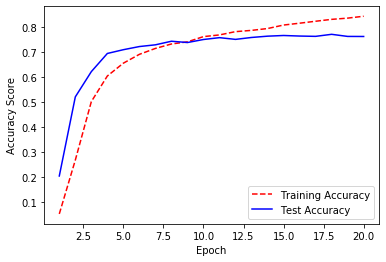

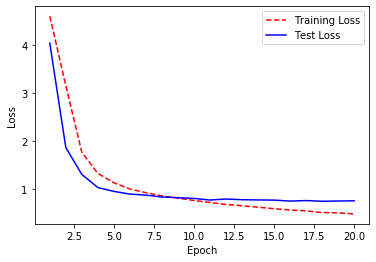

(None, None)

In [366]:
plot_accuracy(net_2e), plot_loss(net_2e)

Accuracy - 76%

#### Model 16 - model 2f - model 2d with l2 regularization

In [367]:
model_2f = Sequential()
model_2f.add(Dense(1000, activation = 'relu',kernel_initializer='glorot_normal', input_shape = train_arr[0].shape))
model_2f.add(Dropout(0.25))
model_2f.add(Dense(750, activation = 'relu'))
model_2f.add(Dense(500, activation = 'relu'))
model_2f.add(Dropout(0.25))
model_2f.add(Dense(240, activation = 'relu'))
model_2f.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2f.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_33 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_131 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_34 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_133 (Dense)            (None, 120)             

In [368]:
model_2f.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [369]:
net_2f = model_2f.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 14s - loss: 6.0743 - accuracy: 0.0563 - val_loss: 5.3064 - val_accuracy: 0.2344
Epoch 2/30


 - 12s - loss: 4.3926 - accuracy: 0.2934 - val_loss: 3.1161 - val_accuracy: 0.5333
Epoch 3/30


 - 12s - loss: 3.0145 - accuracy: 0.5175 - val_loss: 2.4572 - val_accuracy: 0.6495
Epoch 4/30


 - 12s - loss: 2.5076 - accuracy: 0.6105 - val_loss: 2.1716 - val_accuracy: 0.6789
Epoch 5/30


 - 14s - loss: 2.2175 - accuracy: 0.6607 - val_loss: 2.0297 - val_accuracy: 0.6927
Epoch 6/30


 - 14s - loss: 2.0186 - accuracy: 0.6879 - val_loss: 1.8678 - val_accuracy: 0.7213
Epoch 7/30


 - 15s - loss: 1.8610 - accuracy: 0.7062 - val_loss: 1.7453 - val_accuracy: 0.7322
Epoch 8/30


 - 12s - loss: 1.7335 - accuracy: 0.7231 - val_loss: 1.6885 - val_accuracy: 0.7191
Epoch 9/30


 - 12s - loss: 1.6127 - accuracy: 0.7382 - val_loss: 1.5827 - val_accuracy: 0.7362
Epoch 10/30


 - 12s - loss: 1.5141 - accuracy: 0.7472 - val_loss: 1.5097 - val_accuracy: 0.7411
Epoch 11/30


 - 12s - loss: 1.4329 - accuracy: 0.7544 - val_loss: 1.4411 - val_accuracy: 0.7443
Epoch 12/30


 - 12s - loss: 1.3435 - accuracy: 0.7622 - val_loss: 1.4002 - val_accuracy: 0.7396
Epoch 13/30


 - 12s - loss: 1.2804 - accuracy: 0.7715 - val_loss: 1.3242 - val_accuracy: 0.7547
Epoch 14/30


 - 12s - loss: 1.2208 - accuracy: 0.7779 - val_loss: 1.2960 - val_accuracy: 0.7495
Epoch 15/30


 - 11s - loss: 1.1594 - accuracy: 0.7838 - val_loss: 1.2940 - val_accuracy: 0.7441
Epoch 16/30


 - 12s - loss: 1.1095 - accuracy: 0.7875 - val_loss: 1.2111 - val_accuracy: 0.7542
Epoch 17/30


 - 12s - loss: 1.0585 - accuracy: 0.7953 - val_loss: 1.2350 - val_accuracy: 0.7436
Epoch 18/30


 - 12s - loss: 1.0264 - accuracy: 0.7938 - val_loss: 1.1651 - val_accuracy: 0.7601
Epoch 19/30


 - 12s - loss: 0.9851 - accuracy: 0.7992 - val_loss: 1.1312 - val_accuracy: 0.7537
Epoch 20/30


 - 12s - loss: 0.9493 - accuracy: 0.8045 - val_loss: 1.1297 - val_accuracy: 0.7562
Epoch 21/30


 - 15s - loss: 0.9188 - accuracy: 0.8077 - val_loss: 1.1001 - val_accuracy: 0.7626
Epoch 22/30


 - 15s - loss: 0.8918 - accuracy: 0.8133 - val_loss: 1.0571 - val_accuracy: 0.7646
Epoch 23/30


 - 15s - loss: 0.8668 - accuracy: 0.8136 - val_loss: 1.0576 - val_accuracy: 0.7584
Epoch 24/30


 - 15s - loss: 0.8453 - accuracy: 0.8185 - val_loss: 1.0704 - val_accuracy: 0.7579
Epoch 25/30


 - 14s - loss: 0.8176 - accuracy: 0.8184 - val_loss: 1.0401 - val_accuracy: 0.7666
Epoch 26/30


 - 12s - loss: 0.7966 - accuracy: 0.8271 - val_loss: 1.0367 - val_accuracy: 0.7658
Epoch 27/30


 - 12s - loss: 0.7675 - accuracy: 0.8321 - val_loss: 1.0173 - val_accuracy: 0.7666
Epoch 28/30


 - 12s - loss: 0.7577 - accuracy: 0.8303 - val_loss: 1.0035 - val_accuracy: 0.7663
Epoch 29/30


 - 11s - loss: 0.7355 - accuracy: 0.8348 - val_loss: 1.0002 - val_accuracy: 0.7601
Epoch 30/30


 - 12s - loss: 0.7243 - accuracy: 0.8355 - val_loss: 0.9875 - val_accuracy: 0.7678


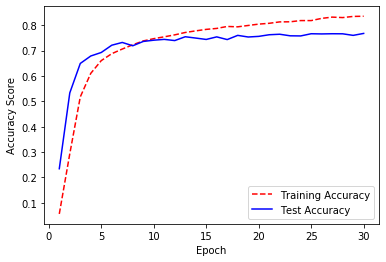

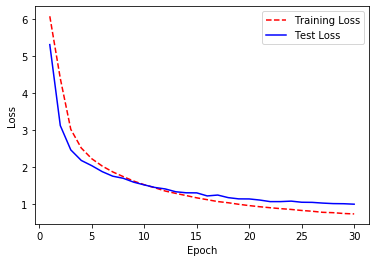

(None, None)

In [370]:
plot_accuracy(net_2f), plot_loss(net_2f)

Accuracy - 76.5% - lower that without regularization

#### Model 17 - model 2g - activation - 'tanh'

In [371]:
model_2g = Sequential()
model_2g.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2g.add(Dropout(0.25))
model_2g.add(Dense(750, activation = 'tanh'))
model_2g.add(Dense(500, activation = 'tanh'))
model_2g.add(Dropout(0.25))
model_2g.add(Dense(240, activation = 'tanh'))
model_2g.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2g.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_135 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_136 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_36 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_138 (Dense)            (None, 120)             

In [372]:
model_2g.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [ ]:
net_2g = model_2g.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

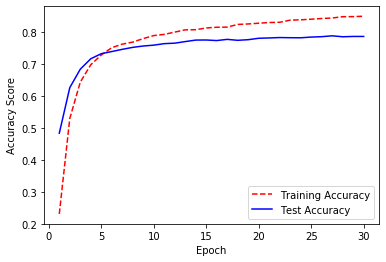

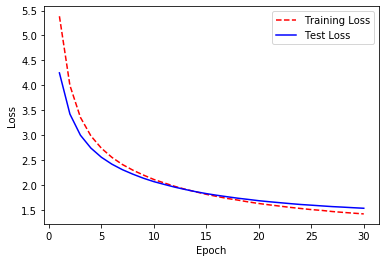

(None, None)

In [374]:
plot_accuracy(net_2g), plot_loss(net_2g)

In [ ]:
#more training
net_2g = model_2g.fit(train_arr, y_train, epochs = 10, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

In [ ]:
#more training
net_2g = model_2g.fit(train_arr, y_train, epochs = 20, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

In [379]:
#more training
net_2g = model_2g.fit(train_arr, y_train, epochs = 50, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/50


 - 12s - loss: 1.1435 - accuracy: 0.8954 - val_loss: 1.3796 - val_accuracy: 0.7883
Epoch 2/50


 - 11s - loss: 1.1377 - accuracy: 0.8954 - val_loss: 1.3746 - val_accuracy: 0.7930
Epoch 3/50


 - 10s - loss: 1.1333 - accuracy: 0.8967 - val_loss: 1.3724 - val_accuracy: 0.7925
Epoch 4/50


 - 10s - loss: 1.1281 - accuracy: 0.8994 - val_loss: 1.3706 - val_accuracy: 0.7922
Epoch 5/50


 - 16s - loss: 1.1209 - accuracy: 0.9012 - val_loss: 1.3690 - val_accuracy: 0.7917
Epoch 6/50


 - 13s - loss: 1.1153 - accuracy: 0.9013 - val_loss: 1.3681 - val_accuracy: 0.7920
Epoch 7/50


 - 10s - loss: 1.1117 - accuracy: 0.9058 - val_loss: 1.3659 - val_accuracy: 0.7913
Epoch 8/50


 - 10s - loss: 1.1059 - accuracy: 0.9055 - val_loss: 1.3641 - val_accuracy: 0.7885
Epoch 9/50


 - 11s - loss: 1.1005 - accuracy: 0.9053 - val_loss: 1.3623 - val_accuracy: 0.7883
Epoch 10/50


 - 10s - loss: 1.0964 - accuracy: 0.9077 - val_loss: 1.3591 - val_accuracy: 0.7925
Epoch 11/50


 - 10s - loss: 1.0924 - accuracy: 0.9085 - val_loss: 1.3579 - val_accuracy: 0.7922
Epoch 12/50


 - 10s - loss: 1.0865 - accuracy: 0.9073 - val_loss: 1.3549 - val_accuracy: 0.7915
Epoch 13/50


 - 10s - loss: 1.0819 - accuracy: 0.9117 - val_loss: 1.3558 - val_accuracy: 0.7913
Epoch 14/50


 - 11s - loss: 1.0794 - accuracy: 0.9088 - val_loss: 1.3510 - val_accuracy: 0.7955
Epoch 15/50


 - 10s - loss: 1.0730 - accuracy: 0.9148 - val_loss: 1.3512 - val_accuracy: 0.7935
Epoch 16/50


 - 10s - loss: 1.0699 - accuracy: 0.9112 - val_loss: 1.3509 - val_accuracy: 0.7920
Epoch 17/50


 - 10s - loss: 1.0632 - accuracy: 0.9132 - val_loss: 1.3490 - val_accuracy: 0.7927
Epoch 18/50


 - 10s - loss: 1.0597 - accuracy: 0.9152 - val_loss: 1.3476 - val_accuracy: 0.7905
Epoch 19/50


 - 11s - loss: 1.0562 - accuracy: 0.9156 - val_loss: 1.3446 - val_accuracy: 0.7947
Epoch 20/50


 - 11s - loss: 1.0525 - accuracy: 0.9169 - val_loss: 1.3414 - val_accuracy: 0.7942
Epoch 21/50


 - 12s - loss: 1.0479 - accuracy: 0.9177 - val_loss: 1.3420 - val_accuracy: 0.7932
Epoch 22/50


 - 12s - loss: 1.0424 - accuracy: 0.9204 - val_loss: 1.3421 - val_accuracy: 0.7920
Epoch 23/50


 - 12s - loss: 1.0396 - accuracy: 0.9197 - val_loss: 1.3382 - val_accuracy: 0.7942
Epoch 24/50


 - 12s - loss: 1.0350 - accuracy: 0.9208 - val_loss: 1.3361 - val_accuracy: 0.7917
Epoch 25/50


 - 11s - loss: 1.0294 - accuracy: 0.9222 - val_loss: 1.3371 - val_accuracy: 0.7920
Epoch 26/50


 - 10s - loss: 1.0262 - accuracy: 0.9225 - val_loss: 1.3360 - val_accuracy: 0.7937
Epoch 27/50


 - 11s - loss: 1.0243 - accuracy: 0.9244 - val_loss: 1.3347 - val_accuracy: 0.7955
Epoch 28/50


 - 11s - loss: 1.0199 - accuracy: 0.9252 - val_loss: 1.3328 - val_accuracy: 0.7930
Epoch 29/50


 - 11s - loss: 1.0146 - accuracy: 0.9258 - val_loss: 1.3329 - val_accuracy: 0.7913
Epoch 30/50


 - 13s - loss: 1.0129 - accuracy: 0.9239 - val_loss: 1.3304 - val_accuracy: 0.7917
Epoch 31/50


 - 11s - loss: 1.0072 - accuracy: 0.9271 - val_loss: 1.3299 - val_accuracy: 0.7890
Epoch 32/50


 - 10s - loss: 1.0057 - accuracy: 0.9280 - val_loss: 1.3281 - val_accuracy: 0.7935
Epoch 33/50


 - 10s - loss: 0.9987 - accuracy: 0.9294 - val_loss: 1.3273 - val_accuracy: 0.7917
Epoch 34/50


 - 10s - loss: 0.9993 - accuracy: 0.9279 - val_loss: 1.3247 - val_accuracy: 0.7969
Epoch 35/50


 - 10s - loss: 0.9937 - accuracy: 0.9296 - val_loss: 1.3251 - val_accuracy: 0.7917
Epoch 36/50


 - 10s - loss: 0.9899 - accuracy: 0.9327 - val_loss: 1.3251 - val_accuracy: 0.7947
Epoch 37/50


 - 10s - loss: 0.9899 - accuracy: 0.9300 - val_loss: 1.3225 - val_accuracy: 0.7947
Epoch 38/50


 - 10s - loss: 0.9813 - accuracy: 0.9353 - val_loss: 1.3221 - val_accuracy: 0.7962
Epoch 39/50


 - 10s - loss: 0.9802 - accuracy: 0.9346 - val_loss: 1.3195 - val_accuracy: 0.7930
Epoch 40/50


 - 10s - loss: 0.9753 - accuracy: 0.9346 - val_loss: 1.3215 - val_accuracy: 0.7910
Epoch 41/50


 - 9s - loss: 0.9750 - accuracy: 0.9335 - val_loss: 1.3204 - val_accuracy: 0.7935
Epoch 42/50


 - 10s - loss: 0.9698 - accuracy: 0.9356 - val_loss: 1.3200 - val_accuracy: 0.7930
Epoch 43/50


 - 11s - loss: 0.9647 - accuracy: 0.9380 - val_loss: 1.3165 - val_accuracy: 0.7932
Epoch 44/50


 - 9s - loss: 0.9649 - accuracy: 0.9370 - val_loss: 1.3152 - val_accuracy: 0.7925
Epoch 45/50


 - 10s - loss: 0.9608 - accuracy: 0.9375 - val_loss: 1.3169 - val_accuracy: 0.7917
Epoch 46/50


 - 9s - loss: 0.9588 - accuracy: 0.9388 - val_loss: 1.3125 - val_accuracy: 0.7952
Epoch 47/50


 - 9s - loss: 0.9552 - accuracy: 0.9377 - val_loss: 1.3135 - val_accuracy: 0.7925
Epoch 48/50


 - 9s - loss: 0.9526 - accuracy: 0.9384 - val_loss: 1.3134 - val_accuracy: 0.7925
Epoch 49/50


 - 10s - loss: 0.9477 - accuracy: 0.9403 - val_loss: 1.3111 - val_accuracy: 0.7920
Epoch 50/50


 - 10s - loss: 0.9443 - accuracy: 0.9413 - val_loss: 1.3135 - val_accuracy: 0.7915


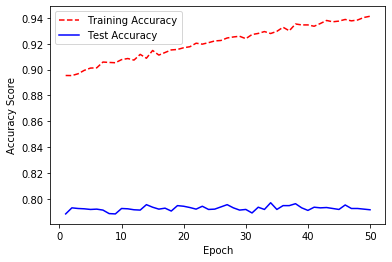

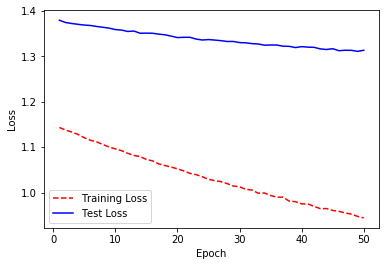

(None, None)

In [380]:
plot_accuracy(net_2g), plot_loss(net_2g)

Accuracy over 79%, multiple retraining of the model to improve accuracy

#### Model 18 - model 2h - activation - 'tanh' and 'relu'

In [384]:
model_2h = Sequential()
model_2h.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2h.add(Dropout(0.25))
model_2h.add(Dense(750, activation = 'relu'))
model_2h.add(Dense(500, activation = 'tanh'))
model_2h.add(Dropout(0.25))
model_2h.add(Dense(240, activation = 'relu'))
model_2h.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2h.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_39 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_145 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_146 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_40 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_148 (Dense)            (None, 120)             

In [385]:
model_2h.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [ ]:
net_2h = model_2h.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

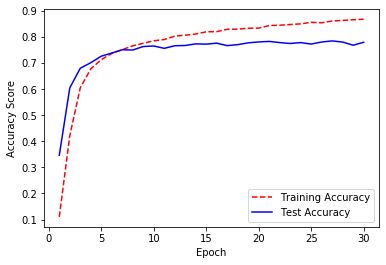

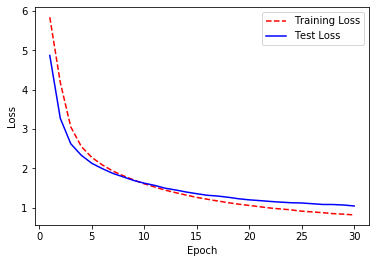

(None, None)

In [387]:
plot_accuracy(net_2h), plot_loss(net_2h)

In [ ]:
net_2h = model_2h.fit(train_arr, y_train, epochs = 100, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

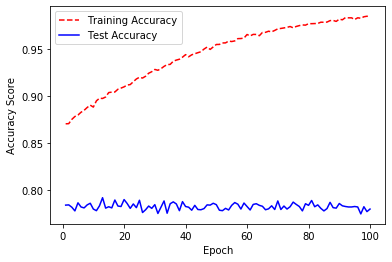

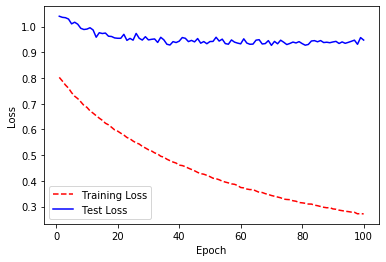

(None, None)

In [389]:
plot_accuracy(net_2h), plot_loss(net_2h)

Accuracy at the level of 78%

#### Model 19 - model 2i - activation - 'relu' and l2 regularization

In [390]:
model_2i = Sequential()
model_2i.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_2i.add(Dropout(0.25))
model_2i.add(Dense(750, activation = 'relu'))
model_2i.add(Dense(500, activation = 'relu'))
model_2i.add(Dropout(0.25))
model_2i.add(Dense(240, activation = 'relu'))
model_2i.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2i.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_41 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_150 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_151 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_42 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_153 (Dense)            (None, 120)             

In [391]:
model_2i.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [392]:
net_2i = model_2i.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 12s - loss: 6.1179 - accuracy: 0.0518 - val_loss: 5.4760 - val_accuracy: 0.2330
Epoch 2/30


 - 11s - loss: 4.6108 - accuracy: 0.2636 - val_loss: 3.3970 - val_accuracy: 0.4380
Epoch 3/30


 - 11s - loss: 3.1045 - accuracy: 0.5010 - val_loss: 2.4932 - val_accuracy: 0.6425
Epoch 4/30


 - 11s - loss: 2.5278 - accuracy: 0.6090 - val_loss: 2.2055 - val_accuracy: 0.6789
Epoch 5/30


 - 10s - loss: 2.2274 - accuracy: 0.6576 - val_loss: 2.0224 - val_accuracy: 0.7050
Epoch 6/30


 - 10s - loss: 2.0169 - accuracy: 0.6854 - val_loss: 1.8672 - val_accuracy: 0.7184
Epoch 7/30


 - 10s - loss: 1.8620 - accuracy: 0.7101 - val_loss: 1.7377 - val_accuracy: 0.7381
Epoch 8/30


 - 8s - loss: 1.7316 - accuracy: 0.7217 - val_loss: 1.6390 - val_accuracy: 0.7431
Epoch 9/30


 - 8s - loss: 1.6152 - accuracy: 0.7365 - val_loss: 1.5979 - val_accuracy: 0.7278
Epoch 10/30


 - 9s - loss: 1.5090 - accuracy: 0.7459 - val_loss: 1.4966 - val_accuracy: 0.7453
Epoch 11/30


 - 10s - loss: 1.4283 - accuracy: 0.7521 - val_loss: 1.4152 - val_accuracy: 0.7574
Epoch 12/30


 - 10s - loss: 1.3442 - accuracy: 0.7623 - val_loss: 1.3895 - val_accuracy: 0.7404
Epoch 13/30


 - 9s - loss: 1.2729 - accuracy: 0.7737 - val_loss: 1.3489 - val_accuracy: 0.7401
Epoch 14/30


 - 11s - loss: 1.2135 - accuracy: 0.7789 - val_loss: 1.3310 - val_accuracy: 0.7404
Epoch 15/30


 - 10s - loss: 1.1639 - accuracy: 0.7802 - val_loss: 1.2437 - val_accuracy: 0.7559
Epoch 16/30


 - 9s - loss: 1.1109 - accuracy: 0.7868 - val_loss: 1.2069 - val_accuracy: 0.7569
Epoch 17/30


 - 9s - loss: 1.0540 - accuracy: 0.7966 - val_loss: 1.1902 - val_accuracy: 0.7520
Epoch 18/30


 - 9s - loss: 1.0147 - accuracy: 0.7999 - val_loss: 1.1496 - val_accuracy: 0.7525
Epoch 19/30


 - 9s - loss: 0.9790 - accuracy: 0.8037 - val_loss: 1.1334 - val_accuracy: 0.7557
Epoch 20/30


 - 9s - loss: 0.9405 - accuracy: 0.8073 - val_loss: 1.1334 - val_accuracy: 0.7515
Epoch 21/30


 - 9s - loss: 0.9201 - accuracy: 0.8057 - val_loss: 1.1072 - val_accuracy: 0.7562
Epoch 22/30


 - 9s - loss: 0.8830 - accuracy: 0.8146 - val_loss: 1.0562 - val_accuracy: 0.7559
Epoch 23/30


 - 9s - loss: 0.8602 - accuracy: 0.8164 - val_loss: 1.0969 - val_accuracy: 0.7517
Epoch 24/30


 - 9s - loss: 0.8407 - accuracy: 0.8200 - val_loss: 1.1029 - val_accuracy: 0.7453
Epoch 25/30


 - 10s - loss: 0.8102 - accuracy: 0.8272 - val_loss: 1.0567 - val_accuracy: 0.7582
Epoch 26/30


 - 12s - loss: 0.7882 - accuracy: 0.8262 - val_loss: 1.0690 - val_accuracy: 0.7473
Epoch 27/30


 - 11s - loss: 0.7712 - accuracy: 0.8280 - val_loss: 1.0078 - val_accuracy: 0.7582
Epoch 28/30


 - 10s - loss: 0.7529 - accuracy: 0.8316 - val_loss: 0.9933 - val_accuracy: 0.7658
Epoch 29/30


 - 11s - loss: 0.7340 - accuracy: 0.8333 - val_loss: 1.0064 - val_accuracy: 0.7626
Epoch 30/30


 - 11s - loss: 0.7152 - accuracy: 0.8377 - val_loss: 1.0149 - val_accuracy: 0.7542


Accuracy - 75%

#### Model 20 - model 2j - activation - 'tanh' and 'adamax' optimizer

In [393]:
model_2j = Sequential()
model_2j.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2j.add(Dropout(0.25))
model_2j.add(Dense(750, activation = 'tanh'))
model_2j.add(Dense(500, activation = 'tanh'))
model_2j.add(Dropout(0.25))
model_2j.add(Dense(240, activation = 'tanh'))
model_2j.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2j.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_43 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_155 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_156 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_44 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_158 (Dense)            (None, 120)             

In [394]:
model_2j.compile(loss='categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])

In [ ]:
net_2j = model_2j.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

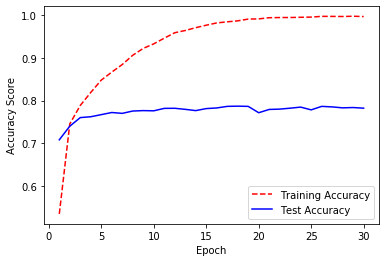

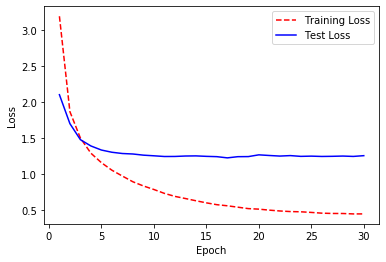

(None, None)

In [396]:
plot_accuracy(net_2j), plot_loss(net_2j)

Accuracy - 78%

#### Model 21 - model 2k - activation - 'tanh' and 'adagrad' optimizer

In [397]:
model_2k = Sequential()
model_2k.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2k.add(Dropout(0.25))
model_2k.add(Dense(750, activation = 'tanh'))
model_2k.add(Dense(500, activation = 'tanh'))
model_2k.add(Dropout(0.25))
model_2k.add(Dense(240, activation = 'tanh'))
model_2k.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2k.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_45 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_160 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_161 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_46 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_163 (Dense)            (None, 120)             

In [398]:
model_2k.compile(loss='categorical_crossentropy', optimizer = 'adagrad', metrics = ['accuracy'])

In [ ]:
net_2k = model_2k.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

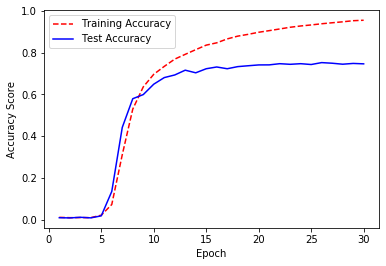

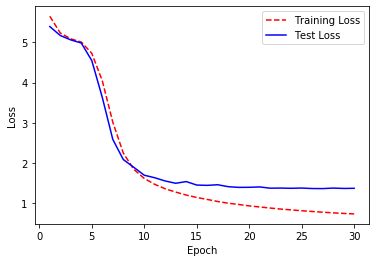

(None, None)

In [400]:
plot_accuracy(net_2k), plot_loss(net_2k)

Accuracy - below 75%

#### Model 22 - model 2l - activation - 'tanh' and 'adadelta' optimizer

In [401]:
model_2l = Sequential()
model_2l.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2l.add(Dropout(0.25))
model_2l.add(Dense(750, activation = 'tanh'))
model_2l.add(Dense(500, activation = 'tanh'))
model_2l.add(Dropout(0.25))
model_2l.add(Dense(240, activation = 'tanh'))
model_2l.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2l.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_47 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_165 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_166 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_48 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_168 (Dense)            (None, 120)             

In [402]:
model_2l.compile(loss='categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

In [ ]:
net_2l = model_2l.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 64, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

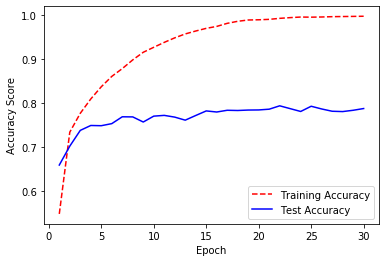

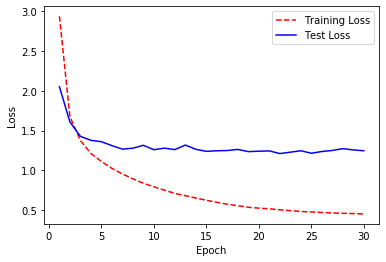

(None, None)

In [404]:
plot_accuracy(net_2l), plot_loss(net_2l)

Accuracy - over 78%

#### Verification of best performing models

In [517]:
model_2c.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 244us/step


[0.756347604449323, 0.7754446864128113]

In [518]:
model_2h.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 260us/step


[0.947334102491145, 0.7793972492218018]

In [523]:
model_2d.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 2s 415us/step


[0.7393547623112738, 0.7848320007324219]

In [526]:
model_2g.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 306us/step


[1.3134857802522983, 0.7915019989013672]

In [527]:
model_2l.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 246us/step


[1.2455729679627852, 0.7868083119392395]

#### Rerunning best performing models with smaller batch and shuffle

In [541]:
model_2cr = Sequential()
model_2cr.add(Dense(1000, activation = 'relu', input_shape = train_arr[0].shape))
model_2cr.add(Dropout(0.25))
model_2cr.add(Dense(750, activation = 'relu'))
model_2cr.add(Dense(500, activation = 'relu'))
model_2cr.add(Dropout(0.25))
model_2cr.add(Dense(240, activation = 'relu'))
model_2cr.add(Dense(120, activation = 'softmax'))
model_2cr.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_58 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_203 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_204 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_59 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_206 (Dense)            (None, 120)             

In [542]:
model_2cr.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy', 'top_k_categorical_accuracy'])

In [543]:
net_2cr = model_2cr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32,shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 18s - loss: 3.8701 - accuracy: 0.1588 - top_k_categorical_accuracy: 0.3683 - val_loss: 1.8817 - val_accuracy: 0.5119 - val_top_k_categorical_accuracy: 0.8622
Epoch 2/30


 - 14s - loss: 1.6257 - accuracy: 0.5371 - top_k_categorical_accuracy: 0.8754 - val_loss: 1.0481 - val_accuracy: 0.6843 - val_top_k_categorical_accuracy: 0.9405
Epoch 3/30


 - 16s - loss: 1.1488 - accuracy: 0.6463 - top_k_categorical_accuracy: 0.9353 - val_loss: 0.9388 - val_accuracy: 0.7129 - val_top_k_categorical_accuracy: 0.9449
Epoch 4/30


 - 16s - loss: 0.9657 - accuracy: 0.7021 - top_k_categorical_accuracy: 0.9511 - val_loss: 0.8512 - val_accuracy: 0.7404 - val_top_k_categorical_accuracy: 0.9560
Epoch 5/30


 - 16s - loss: 0.8563 - accuracy: 0.7298 - top_k_categorical_accuracy: 0.9624 - val_loss: 0.7965 - val_accuracy: 0.7562 - val_top_k_categorical_accuracy: 0.9607
Epoch 6/30


 - 16s - loss: 0.7747 - accuracy: 0.7550 - top_k_categorical_accuracy: 0.9674 - val_loss: 0.7819 - val_accuracy: 0.7584 - val_top_k_categorical_accuracy: 0.9615
Epoch 7/30


 - 16s - loss: 0.7074 - accuracy: 0.7764 - top_k_categorical_accuracy: 0.9744 - val_loss: 0.7891 - val_accuracy: 0.7554 - val_top_k_categorical_accuracy: 0.9620
Epoch 8/30


 - 16s - loss: 0.6451 - accuracy: 0.7909 - top_k_categorical_accuracy: 0.9802 - val_loss: 0.7780 - val_accuracy: 0.7651 - val_top_k_categorical_accuracy: 0.9627
Epoch 9/30


 - 17s - loss: 0.6025 - accuracy: 0.8012 - top_k_categorical_accuracy: 0.9805 - val_loss: 0.7528 - val_accuracy: 0.7700 - val_top_k_categorical_accuracy: 0.9634
Epoch 10/30


 - 16s - loss: 0.5513 - accuracy: 0.8207 - top_k_categorical_accuracy: 0.9840 - val_loss: 0.7735 - val_accuracy: 0.7673 - val_top_k_categorical_accuracy: 0.9587
Epoch 11/30


 - 17s - loss: 0.5170 - accuracy: 0.8305 - top_k_categorical_accuracy: 0.9872 - val_loss: 0.7545 - val_accuracy: 0.7735 - val_top_k_categorical_accuracy: 0.9629
Epoch 12/30


 - 18s - loss: 0.4778 - accuracy: 0.8441 - top_k_categorical_accuracy: 0.9893 - val_loss: 0.7560 - val_accuracy: 0.7787 - val_top_k_categorical_accuracy: 0.9634
Epoch 13/30


 - 16s - loss: 0.4525 - accuracy: 0.8531 - top_k_categorical_accuracy: 0.9910 - val_loss: 0.7466 - val_accuracy: 0.7764 - val_top_k_categorical_accuracy: 0.9634
Epoch 14/30


 - 16s - loss: 0.4165 - accuracy: 0.8616 - top_k_categorical_accuracy: 0.9927 - val_loss: 0.7508 - val_accuracy: 0.7764 - val_top_k_categorical_accuracy: 0.9634
Epoch 15/30


 - 16s - loss: 0.3822 - accuracy: 0.8743 - top_k_categorical_accuracy: 0.9946 - val_loss: 0.7548 - val_accuracy: 0.7708 - val_top_k_categorical_accuracy: 0.9632
Epoch 16/30


 - 16s - loss: 0.3548 - accuracy: 0.8839 - top_k_categorical_accuracy: 0.9958 - val_loss: 0.7749 - val_accuracy: 0.7762 - val_top_k_categorical_accuracy: 0.9620
Epoch 17/30


 - 16s - loss: 0.3335 - accuracy: 0.8923 - top_k_categorical_accuracy: 0.9958 - val_loss: 0.7667 - val_accuracy: 0.7858 - val_top_k_categorical_accuracy: 0.9649
Epoch 18/30


 - 16s - loss: 0.3096 - accuracy: 0.8976 - top_k_categorical_accuracy: 0.9968 - val_loss: 0.7715 - val_accuracy: 0.7720 - val_top_k_categorical_accuracy: 0.9652
Epoch 19/30


 - 16s - loss: 0.2978 - accuracy: 0.9012 - top_k_categorical_accuracy: 0.9965 - val_loss: 0.7958 - val_accuracy: 0.7742 - val_top_k_categorical_accuracy: 0.9647
Epoch 20/30


 - 16s - loss: 0.2710 - accuracy: 0.9140 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.7735 - val_accuracy: 0.7846 - val_top_k_categorical_accuracy: 0.9637
Epoch 21/30


 - 16s - loss: 0.2517 - accuracy: 0.9161 - top_k_categorical_accuracy: 0.9982 - val_loss: 0.8005 - val_accuracy: 0.7799 - val_top_k_categorical_accuracy: 0.9615
Epoch 22/30


 - 16s - loss: 0.2349 - accuracy: 0.9229 - top_k_categorical_accuracy: 0.9981 - val_loss: 0.7950 - val_accuracy: 0.7858 - val_top_k_categorical_accuracy: 0.9622
Epoch 23/30


 - 15s - loss: 0.2216 - accuracy: 0.9278 - top_k_categorical_accuracy: 0.9990 - val_loss: 0.8013 - val_accuracy: 0.7858 - val_top_k_categorical_accuracy: 0.9605
Epoch 24/30


 - 16s - loss: 0.2025 - accuracy: 0.9326 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.8265 - val_accuracy: 0.7863 - val_top_k_categorical_accuracy: 0.9610
Epoch 25/30


 - 15s - loss: 0.1900 - accuracy: 0.9403 - top_k_categorical_accuracy: 0.9994 - val_loss: 0.8318 - val_accuracy: 0.7824 - val_top_k_categorical_accuracy: 0.9627
Epoch 26/30


 - 16s - loss: 0.1803 - accuracy: 0.9413 - top_k_categorical_accuracy: 0.9994 - val_loss: 0.8302 - val_accuracy: 0.7848 - val_top_k_categorical_accuracy: 0.9620
Epoch 27/30


 - 15s - loss: 0.1722 - accuracy: 0.9445 - top_k_categorical_accuracy: 0.9996 - val_loss: 0.8314 - val_accuracy: 0.7843 - val_top_k_categorical_accuracy: 0.9639
Epoch 28/30


 - 15s - loss: 0.1582 - accuracy: 0.9486 - top_k_categorical_accuracy: 0.9995 - val_loss: 0.8310 - val_accuracy: 0.7848 - val_top_k_categorical_accuracy: 0.9654
Epoch 29/30


 - 15s - loss: 0.1483 - accuracy: 0.9536 - top_k_categorical_accuracy: 0.9995 - val_loss: 0.8441 - val_accuracy: 0.7848 - val_top_k_categorical_accuracy: 0.9632
Epoch 30/30


 - 15s - loss: 0.1357 - accuracy: 0.9568 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.8439 - val_accuracy: 0.7848 - val_top_k_categorical_accuracy: 0.9634


In [544]:
model_2cr.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 321us/step


[0.843852234378516, 0.7848320007324219, 0.9634387493133545]

In [545]:
model_2dr = Sequential()
model_2dr.add(Dense(1000, activation = 'relu',kernel_initializer='glorot_normal', input_shape = train_arr[0].shape))
model_2dr.add(Dropout(0.25))
model_2dr.add(Dense(750, activation = 'relu'))
model_2dr.add(Dense(500, activation = 'relu'))
model_2dr.add(Dropout(0.25))
model_2dr.add(Dense(240, activation = 'relu'))
model_2dr.add(Dense(120, activation = 'softmax'))
model_2dr.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_60 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_208 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_209 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_61 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_211 (Dense)            (None, 120)             

In [546]:
model_2dr.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [547]:
net_2dr = model_2dr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32,shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 17s - loss: 3.9362 - accuracy: 0.1458 - val_loss: 1.9218 - val_accuracy: 0.5059
Epoch 2/30


 - 15s - loss: 1.6660 - accuracy: 0.5286 - val_loss: 1.1361 - val_accuracy: 0.6559
Epoch 3/30


 - 15s - loss: 1.1504 - accuracy: 0.6556 - val_loss: 0.9106 - val_accuracy: 0.7255
Epoch 4/30


 - 16s - loss: 0.9671 - accuracy: 0.7020 - val_loss: 0.8457 - val_accuracy: 0.7458
Epoch 5/30


 - 16s - loss: 0.8536 - accuracy: 0.7342 - val_loss: 0.8435 - val_accuracy: 0.7416
Epoch 6/30


 - 16s - loss: 0.7754 - accuracy: 0.7567 - val_loss: 0.8110 - val_accuracy: 0.7540
Epoch 7/30


 - 16s - loss: 0.7035 - accuracy: 0.7785 - val_loss: 0.7743 - val_accuracy: 0.7591
Epoch 8/30


 - 16s - loss: 0.6534 - accuracy: 0.7902 - val_loss: 0.7431 - val_accuracy: 0.7732
Epoch 9/30


 - 16s - loss: 0.5990 - accuracy: 0.8056 - val_loss: 0.7699 - val_accuracy: 0.7685
Epoch 10/30


 - 16s - loss: 0.5573 - accuracy: 0.8168 - val_loss: 0.7489 - val_accuracy: 0.7722
Epoch 11/30


 - 17s - loss: 0.5190 - accuracy: 0.8318 - val_loss: 0.7416 - val_accuracy: 0.7717
Epoch 12/30


 - 16s - loss: 0.4853 - accuracy: 0.8399 - val_loss: 0.7324 - val_accuracy: 0.7774
Epoch 13/30


 - 16s - loss: 0.4477 - accuracy: 0.8530 - val_loss: 0.7591 - val_accuracy: 0.7769
Epoch 14/30


 - 16s - loss: 0.4226 - accuracy: 0.8597 - val_loss: 0.7706 - val_accuracy: 0.7740
Epoch 15/30


 - 18s - loss: 0.3884 - accuracy: 0.8732 - val_loss: 0.7532 - val_accuracy: 0.7779
Epoch 16/30


 - 16s - loss: 0.3663 - accuracy: 0.8762 - val_loss: 0.7723 - val_accuracy: 0.7722
Epoch 17/30


 - 16s - loss: 0.3357 - accuracy: 0.8886 - val_loss: 0.7711 - val_accuracy: 0.7796
Epoch 18/30


 - 16s - loss: 0.3125 - accuracy: 0.8958 - val_loss: 0.7691 - val_accuracy: 0.7764
Epoch 19/30


 - 16s - loss: 0.2924 - accuracy: 0.9024 - val_loss: 0.7734 - val_accuracy: 0.7811
Epoch 20/30


 - 16s - loss: 0.2700 - accuracy: 0.9105 - val_loss: 0.8016 - val_accuracy: 0.7799
Epoch 21/30


 - 16s - loss: 0.2539 - accuracy: 0.9164 - val_loss: 0.7924 - val_accuracy: 0.7806
Epoch 22/30


 - 16s - loss: 0.2348 - accuracy: 0.9212 - val_loss: 0.7993 - val_accuracy: 0.7814
Epoch 23/30


 - 16s - loss: 0.2252 - accuracy: 0.9266 - val_loss: 0.8025 - val_accuracy: 0.7799
Epoch 24/30


 - 16s - loss: 0.2030 - accuracy: 0.9338 - val_loss: 0.8192 - val_accuracy: 0.7856
Epoch 25/30


 - 16s - loss: 0.1907 - accuracy: 0.9364 - val_loss: 0.8446 - val_accuracy: 0.7769
Epoch 26/30


 - 17s - loss: 0.1806 - accuracy: 0.9418 - val_loss: 0.8350 - val_accuracy: 0.7843
Epoch 27/30


 - 15s - loss: 0.1688 - accuracy: 0.9447 - val_loss: 0.8292 - val_accuracy: 0.7883
Epoch 28/30


 - 15s - loss: 0.1532 - accuracy: 0.9506 - val_loss: 0.8561 - val_accuracy: 0.7880
Epoch 29/30


 - 16s - loss: 0.1453 - accuracy: 0.9541 - val_loss: 0.8650 - val_accuracy: 0.7878
Epoch 30/30


 - 15s - loss: 0.1412 - accuracy: 0.9545 - val_loss: 0.8557 - val_accuracy: 0.7858


In [548]:
model_2dr.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 232us/step


[0.8557340186236522, 0.7858201861381531]

In [549]:
model_2gr = Sequential()
model_2gr.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2gr.add(Dropout(0.25))
model_2gr.add(Dense(750, activation = 'tanh'))
model_2gr.add(Dense(500, activation = 'tanh'))
model_2gr.add(Dropout(0.25))
model_2gr.add(Dense(240, activation = 'tanh'))
model_2gr.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2gr.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_62 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_213 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_214 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_63 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_216 (Dense)            (None, 120)             

In [550]:
model_2gr.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy', 'top_k_categorical_accuracy' ])

In [ ]:
net_2gr = model_2gr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32,shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

In [552]:
net_2gr = model_2gr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32,shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 16s - loss: 1.1511 - accuracy: 0.8909 - top_k_categorical_accuracy: 0.9936 - val_loss: 1.3798 - val_accuracy: 0.7856 - val_top_k_categorical_accuracy: 0.9669
Epoch 2/30


 - 15s - loss: 1.1407 - accuracy: 0.8934 - top_k_categorical_accuracy: 0.9941 - val_loss: 1.3767 - val_accuracy: 0.7868 - val_top_k_categorical_accuracy: 0.9671
Epoch 3/30


 - 16s - loss: 1.1301 - accuracy: 0.8943 - top_k_categorical_accuracy: 0.9947 - val_loss: 1.3754 - val_accuracy: 0.7873 - val_top_k_categorical_accuracy: 0.9669
Epoch 4/30


 - 17s - loss: 1.1199 - accuracy: 0.8989 - top_k_categorical_accuracy: 0.9947 - val_loss: 1.3668 - val_accuracy: 0.7858 - val_top_k_categorical_accuracy: 0.9664
Epoch 5/30


 - 16s - loss: 1.1089 - accuracy: 0.9009 - top_k_categorical_accuracy: 0.9955 - val_loss: 1.3644 - val_accuracy: 0.7868 - val_top_k_categorical_accuracy: 0.9667
Epoch 6/30


 - 16s - loss: 1.1012 - accuracy: 0.9033 - top_k_categorical_accuracy: 0.9953 - val_loss: 1.3630 - val_accuracy: 0.7863 - val_top_k_categorical_accuracy: 0.9671
Epoch 7/30


 - 17s - loss: 1.0920 - accuracy: 0.9018 - top_k_categorical_accuracy: 0.9958 - val_loss: 1.3575 - val_accuracy: 0.7856 - val_top_k_categorical_accuracy: 0.9639
Epoch 8/30


 - 17s - loss: 1.0799 - accuracy: 0.9071 - top_k_categorical_accuracy: 0.9958 - val_loss: 1.3536 - val_accuracy: 0.7888 - val_top_k_categorical_accuracy: 0.9652
Epoch 9/30


 - 16s - loss: 1.0716 - accuracy: 0.9100 - top_k_categorical_accuracy: 0.9958 - val_loss: 1.3533 - val_accuracy: 0.7880 - val_top_k_categorical_accuracy: 0.9652
Epoch 10/30


 - 17s - loss: 1.0621 - accuracy: 0.9107 - top_k_categorical_accuracy: 0.9963 - val_loss: 1.3467 - val_accuracy: 0.7871 - val_top_k_categorical_accuracy: 0.9669
Epoch 11/30


 - 16s - loss: 1.0548 - accuracy: 0.9130 - top_k_categorical_accuracy: 0.9956 - val_loss: 1.3467 - val_accuracy: 0.7895 - val_top_k_categorical_accuracy: 0.9657
Epoch 12/30


 - 16s - loss: 1.0496 - accuracy: 0.9153 - top_k_categorical_accuracy: 0.9959 - val_loss: 1.3435 - val_accuracy: 0.7915 - val_top_k_categorical_accuracy: 0.9667
Epoch 13/30


 - 17s - loss: 1.0395 - accuracy: 0.9164 - top_k_categorical_accuracy: 0.9966 - val_loss: 1.3403 - val_accuracy: 0.7895 - val_top_k_categorical_accuracy: 0.9659
Epoch 14/30


 - 16s - loss: 1.0322 - accuracy: 0.9192 - top_k_categorical_accuracy: 0.9967 - val_loss: 1.3348 - val_accuracy: 0.7888 - val_top_k_categorical_accuracy: 0.9652
Epoch 15/30


 - 15s - loss: 1.0237 - accuracy: 0.9206 - top_k_categorical_accuracy: 0.9966 - val_loss: 1.3335 - val_accuracy: 0.7925 - val_top_k_categorical_accuracy: 0.9664
Epoch 16/30


 - 15s - loss: 1.0158 - accuracy: 0.9222 - top_k_categorical_accuracy: 0.9972 - val_loss: 1.3328 - val_accuracy: 0.7905 - val_top_k_categorical_accuracy: 0.9667
Epoch 17/30


 - 15s - loss: 1.0109 - accuracy: 0.9224 - top_k_categorical_accuracy: 0.9972 - val_loss: 1.3337 - val_accuracy: 0.7900 - val_top_k_categorical_accuracy: 0.9662
Epoch 18/30


 - 15s - loss: 1.0041 - accuracy: 0.9235 - top_k_categorical_accuracy: 0.9972 - val_loss: 1.3316 - val_accuracy: 0.7888 - val_top_k_categorical_accuracy: 0.9667
Epoch 19/30


 - 15s - loss: 0.9951 - accuracy: 0.9264 - top_k_categorical_accuracy: 0.9973 - val_loss: 1.3260 - val_accuracy: 0.7873 - val_top_k_categorical_accuracy: 0.9642
Epoch 20/30


 - 15s - loss: 0.9891 - accuracy: 0.9282 - top_k_categorical_accuracy: 0.9973 - val_loss: 1.3261 - val_accuracy: 0.7905 - val_top_k_categorical_accuracy: 0.9647
Epoch 21/30


 - 15s - loss: 0.9832 - accuracy: 0.9295 - top_k_categorical_accuracy: 0.9975 - val_loss: 1.3246 - val_accuracy: 0.7875 - val_top_k_categorical_accuracy: 0.9671
Epoch 22/30


 - 16s - loss: 0.9754 - accuracy: 0.9326 - top_k_categorical_accuracy: 0.9978 - val_loss: 1.3213 - val_accuracy: 0.7930 - val_top_k_categorical_accuracy: 0.9647
Epoch 23/30


 - 16s - loss: 0.9695 - accuracy: 0.9326 - top_k_categorical_accuracy: 0.9979 - val_loss: 1.3220 - val_accuracy: 0.7903 - val_top_k_categorical_accuracy: 0.9620
Epoch 24/30


 - 16s - loss: 0.9607 - accuracy: 0.9368 - top_k_categorical_accuracy: 0.9973 - val_loss: 1.3201 - val_accuracy: 0.7878 - val_top_k_categorical_accuracy: 0.9634
Epoch 25/30


 - 15s - loss: 0.9574 - accuracy: 0.9339 - top_k_categorical_accuracy: 0.9980 - val_loss: 1.3199 - val_accuracy: 0.7890 - val_top_k_categorical_accuracy: 0.9647
Epoch 26/30


 - 15s - loss: 0.9522 - accuracy: 0.9366 - top_k_categorical_accuracy: 0.9976 - val_loss: 1.3176 - val_accuracy: 0.7885 - val_top_k_categorical_accuracy: 0.9654
Epoch 27/30


 - 15s - loss: 0.9444 - accuracy: 0.9393 - top_k_categorical_accuracy: 0.9977 - val_loss: 1.3149 - val_accuracy: 0.7890 - val_top_k_categorical_accuracy: 0.9639
Epoch 28/30


 - 15s - loss: 0.9388 - accuracy: 0.9410 - top_k_categorical_accuracy: 0.9982 - val_loss: 1.3156 - val_accuracy: 0.7895 - val_top_k_categorical_accuracy: 0.9649
Epoch 29/30


 - 15s - loss: 0.9332 - accuracy: 0.9391 - top_k_categorical_accuracy: 0.9980 - val_loss: 1.3072 - val_accuracy: 0.7908 - val_top_k_categorical_accuracy: 0.9644
Epoch 30/30


 - 15s - loss: 0.9263 - accuracy: 0.9437 - top_k_categorical_accuracy: 0.9979 - val_loss: 1.3119 - val_accuracy: 0.7861 - val_top_k_categorical_accuracy: 0.9642


In [553]:
model_2gr.evaluate(valid_arr, y_val)

4048/4048 [==============================] - 1s 302us/step


[1.311940971570524, 0.7860671877861023, 0.9641798138618469]

In [554]:
model_2jr = Sequential()
model_2jr.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2jr.add(Dropout(0.25))
model_2jr.add(Dense(750, activation = 'tanh'))
model_2jr.add(Dense(500, activation = 'tanh'))
model_2jr.add(Dropout(0.25))
model_2jr.add(Dense(240, activation = 'tanh'))
model_2jr.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2jr.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_64 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_218 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_219 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_65 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_221 (Dense)            (None, 120)             

In [555]:
model_2jr.compile(loss='categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy', 'top_k_categorical_accuracy'])

In [557]:
net_2jr = model_2jr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32, shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 31s - loss: 3.0980 - accuracy: 0.5342 - top_k_categorical_accuracy: 0.8225 - val_loss: 2.0581 - val_accuracy: 0.6855 - val_top_k_categorical_accuracy: 0.9449
Epoch 2/30


 - 32s - loss: 1.7811 - accuracy: 0.7312 - top_k_categorical_accuracy: 0.9599 - val_loss: 1.6232 - val_accuracy: 0.7196 - val_top_k_categorical_accuracy: 0.9553
Epoch 3/30


 - 35s - loss: 1.4353 - accuracy: 0.7749 - top_k_categorical_accuracy: 0.9718 - val_loss: 1.4843 - val_accuracy: 0.7273 - val_top_k_categorical_accuracy: 0.9518
Epoch 4/30


 - 34s - loss: 1.2475 - accuracy: 0.8068 - top_k_categorical_accuracy: 0.9786 - val_loss: 1.3670 - val_accuracy: 0.7579 - val_top_k_categorical_accuracy: 0.9543
Epoch 5/30


 - 33s - loss: 1.1203 - accuracy: 0.8354 - top_k_categorical_accuracy: 0.9843 - val_loss: 1.3303 - val_accuracy: 0.7490 - val_top_k_categorical_accuracy: 0.9587
Epoch 6/30


 - 33s - loss: 1.0285 - accuracy: 0.8550 - top_k_categorical_accuracy: 0.9886 - val_loss: 1.2968 - val_accuracy: 0.7601 - val_top_k_categorical_accuracy: 0.9580
Epoch 7/30


 - 35s - loss: 0.9525 - accuracy: 0.8776 - top_k_categorical_accuracy: 0.9907 - val_loss: 1.2678 - val_accuracy: 0.7693 - val_top_k_categorical_accuracy: 0.9560
Epoch 8/30


 - 35s - loss: 0.8820 - accuracy: 0.8993 - top_k_categorical_accuracy: 0.9949 - val_loss: 1.2602 - val_accuracy: 0.7693 - val_top_k_categorical_accuracy: 0.9565
Epoch 9/30


 - 33s - loss: 0.8223 - accuracy: 0.9169 - top_k_categorical_accuracy: 0.9952 - val_loss: 1.2523 - val_accuracy: 0.7710 - val_top_k_categorical_accuracy: 0.9627
Epoch 10/30


 - 32s - loss: 0.7761 - accuracy: 0.9301 - top_k_categorical_accuracy: 0.9962 - val_loss: 1.2552 - val_accuracy: 0.7693 - val_top_k_categorical_accuracy: 0.9548
Epoch 11/30


 - 34s - loss: 0.7313 - accuracy: 0.9408 - top_k_categorical_accuracy: 0.9977 - val_loss: 1.2312 - val_accuracy: 0.7794 - val_top_k_categorical_accuracy: 0.9580
Epoch 12/30


 - 33s - loss: 0.6889 - accuracy: 0.9531 - top_k_categorical_accuracy: 0.9984 - val_loss: 1.2398 - val_accuracy: 0.7799 - val_top_k_categorical_accuracy: 0.9573
Epoch 13/30


 - 32s - loss: 0.6538 - accuracy: 0.9618 - top_k_categorical_accuracy: 0.9990 - val_loss: 1.2295 - val_accuracy: 0.7759 - val_top_k_categorical_accuracy: 0.9570
Epoch 14/30


 - 33s - loss: 0.6264 - accuracy: 0.9676 - top_k_categorical_accuracy: 0.9989 - val_loss: 1.2330 - val_accuracy: 0.7804 - val_top_k_categorical_accuracy: 0.9573
Epoch 15/30


 - 34s - loss: 0.5996 - accuracy: 0.9738 - top_k_categorical_accuracy: 0.9992 - val_loss: 1.2360 - val_accuracy: 0.7759 - val_top_k_categorical_accuracy: 0.9560
Epoch 16/30


 - 32s - loss: 0.5722 - accuracy: 0.9799 - top_k_categorical_accuracy: 0.9992 - val_loss: 1.2412 - val_accuracy: 0.7789 - val_top_k_categorical_accuracy: 0.9526
Epoch 17/30


 - 27s - loss: 0.5552 - accuracy: 0.9822 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2528 - val_accuracy: 0.7725 - val_top_k_categorical_accuracy: 0.9558
Epoch 18/30


 - 29s - loss: 0.5377 - accuracy: 0.9847 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2435 - val_accuracy: 0.7732 - val_top_k_categorical_accuracy: 0.9548
Epoch 19/30


 - 27s - loss: 0.5206 - accuracy: 0.9883 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2539 - val_accuracy: 0.7745 - val_top_k_categorical_accuracy: 0.9526
Epoch 20/30


 - 29s - loss: 0.5124 - accuracy: 0.9893 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2381 - val_accuracy: 0.7782 - val_top_k_categorical_accuracy: 0.9536
Epoch 21/30


 - 27s - loss: 0.4981 - accuracy: 0.9910 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2442 - val_accuracy: 0.7787 - val_top_k_categorical_accuracy: 0.9548
Epoch 22/30


 - 29s - loss: 0.4892 - accuracy: 0.9925 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2665 - val_accuracy: 0.7737 - val_top_k_categorical_accuracy: 0.9536
Epoch 23/30


 - 29s - loss: 0.4819 - accuracy: 0.9929 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2538 - val_accuracy: 0.7735 - val_top_k_categorical_accuracy: 0.9516
Epoch 24/30


 - 32s - loss: 0.4684 - accuracy: 0.9951 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2429 - val_accuracy: 0.7794 - val_top_k_categorical_accuracy: 0.9541
Epoch 25/30


 - 35s - loss: 0.4661 - accuracy: 0.9946 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2475 - val_accuracy: 0.7804 - val_top_k_categorical_accuracy: 0.9545
Epoch 26/30


 - 29s - loss: 0.4615 - accuracy: 0.9952 - top_k_categorical_accuracy: 0.9999 - val_loss: 1.2562 - val_accuracy: 0.7762 - val_top_k_categorical_accuracy: 0.9511
Epoch 27/30


 - 32s - loss: 0.4560 - accuracy: 0.9962 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2532 - val_accuracy: 0.7784 - val_top_k_categorical_accuracy: 0.9506
Epoch 28/30


 - 32s - loss: 0.4514 - accuracy: 0.9962 - top_k_categorical_accuracy: 0.9999 - val_loss: 1.2449 - val_accuracy: 0.7819 - val_top_k_categorical_accuracy: 0.9533
Epoch 29/30


 - 32s - loss: 0.4495 - accuracy: 0.9960 - top_k_categorical_accuracy: 0.9999 - val_loss: 1.2562 - val_accuracy: 0.7784 - val_top_k_categorical_accuracy: 0.9513
Epoch 30/30


 - 31s - loss: 0.4438 - accuracy: 0.9967 - top_k_categorical_accuracy: 0.9999 - val_loss: 1.2721 - val_accuracy: 0.7804 - val_top_k_categorical_accuracy: 0.9521


In [ ]:
model_2jr.evaluate(valid_arr, y_val)

In [558]:
model_2lr = Sequential()
model_2lr.add(Dense(1000, activation = 'tanh', input_shape = train_arr[0].shape))
model_2lr.add(Dropout(0.25))
model_2lr.add(Dense(750, activation = 'tanh'))
model_2lr.add(Dense(500, activation = 'tanh'))
model_2lr.add(Dropout(0.25))
model_2lr.add(Dense(240, activation = 'tanh'))
model_2lr.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2lr.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 1000)              2049000   
_________________________________________________________________
dropout_66 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_223 (Dense)            (None, 750)               750750    
_________________________________________________________________
dense_224 (Dense)            (None, 500)               375500    
_________________________________________________________________
dropout_67 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 240)               120240    
_________________________________________________________________
dense_226 (Dense)            (None, 120)             

In [559]:
model_2lr.compile(loss='categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy', 'top_k_categorical_accuracy'])

In [560]:
net_2lr = model_2lr.fit(train_arr, y_train, epochs = 30, verbose = 2, batch_size = 32,shuffle = True, callbacks=[TQDMNotebookCallback()], validation_data = (valid_arr, y_val))

Train on 16532 samples, validate on 4048 samples


Epoch 1/30


 - 37s - loss: 2.8032 - accuracy: 0.5468 - top_k_categorical_accuracy: 0.8430 - val_loss: 1.8481 - val_accuracy: 0.6835 - val_top_k_categorical_accuracy: 0.9405
Epoch 2/30


 - 33s - loss: 1.6109 - accuracy: 0.7226 - top_k_categorical_accuracy: 0.9569 - val_loss: 1.5395 - val_accuracy: 0.7115 - val_top_k_categorical_accuracy: 0.9449
Epoch 3/30


 - 32s - loss: 1.3415 - accuracy: 0.7672 - top_k_categorical_accuracy: 0.9699 - val_loss: 1.4665 - val_accuracy: 0.7201 - val_top_k_categorical_accuracy: 0.9484
Epoch 4/30


 - 32s - loss: 1.2089 - accuracy: 0.7974 - top_k_categorical_accuracy: 0.9773 - val_loss: 1.3795 - val_accuracy: 0.7337 - val_top_k_categorical_accuracy: 0.9491
Epoch 5/30


 - 34s - loss: 1.1111 - accuracy: 0.8245 - top_k_categorical_accuracy: 0.9822 - val_loss: 1.3210 - val_accuracy: 0.7517 - val_top_k_categorical_accuracy: 0.9560
Epoch 6/30


 - 34s - loss: 1.0391 - accuracy: 0.8451 - top_k_categorical_accuracy: 0.9852 - val_loss: 1.2969 - val_accuracy: 0.7547 - val_top_k_categorical_accuracy: 0.9560
Epoch 7/30


 - 33s - loss: 0.9793 - accuracy: 0.8637 - top_k_categorical_accuracy: 0.9886 - val_loss: 1.3238 - val_accuracy: 0.7401 - val_top_k_categorical_accuracy: 0.9521
Epoch 8/30


 - 33s - loss: 0.9199 - accuracy: 0.8804 - top_k_categorical_accuracy: 0.9901 - val_loss: 1.2544 - val_accuracy: 0.7685 - val_top_k_categorical_accuracy: 0.9555
Epoch 9/30


 - 40s - loss: 0.8635 - accuracy: 0.8968 - top_k_categorical_accuracy: 0.9924 - val_loss: 1.2646 - val_accuracy: 0.7653 - val_top_k_categorical_accuracy: 0.9573
Epoch 10/30


 - 38s - loss: 0.8195 - accuracy: 0.9100 - top_k_categorical_accuracy: 0.9940 - val_loss: 1.2405 - val_accuracy: 0.7779 - val_top_k_categorical_accuracy: 0.9573
Epoch 11/30


 - 38s - loss: 0.7756 - accuracy: 0.9220 - top_k_categorical_accuracy: 0.9946 - val_loss: 1.2624 - val_accuracy: 0.7695 - val_top_k_categorical_accuracy: 0.9536
Epoch 12/30


 - 36s - loss: 0.7365 - accuracy: 0.9333 - top_k_categorical_accuracy: 0.9958 - val_loss: 1.2639 - val_accuracy: 0.7688 - val_top_k_categorical_accuracy: 0.9536
Epoch 13/30


 - 35s - loss: 0.7001 - accuracy: 0.9434 - top_k_categorical_accuracy: 0.9964 - val_loss: 1.2774 - val_accuracy: 0.7745 - val_top_k_categorical_accuracy: 0.9511
Epoch 14/30


 - 36s - loss: 0.6639 - accuracy: 0.9529 - top_k_categorical_accuracy: 0.9973 - val_loss: 1.2468 - val_accuracy: 0.7742 - val_top_k_categorical_accuracy: 0.9511
Epoch 15/30


 - 35s - loss: 0.6353 - accuracy: 0.9603 - top_k_categorical_accuracy: 0.9978 - val_loss: 1.2258 - val_accuracy: 0.7883 - val_top_k_categorical_accuracy: 0.9563
Epoch 16/30


 - 36s - loss: 0.6116 - accuracy: 0.9676 - top_k_categorical_accuracy: 0.9979 - val_loss: 1.2522 - val_accuracy: 0.7727 - val_top_k_categorical_accuracy: 0.9536
Epoch 17/30


 - 35s - loss: 0.5925 - accuracy: 0.9712 - top_k_categorical_accuracy: 0.9986 - val_loss: 1.2524 - val_accuracy: 0.7787 - val_top_k_categorical_accuracy: 0.9508
Epoch 18/30


 - 35s - loss: 0.5720 - accuracy: 0.9750 - top_k_categorical_accuracy: 0.9990 - val_loss: 1.2672 - val_accuracy: 0.7767 - val_top_k_categorical_accuracy: 0.9521
Epoch 19/30


 - 29s - loss: 0.5473 - accuracy: 0.9814 - top_k_categorical_accuracy: 0.9992 - val_loss: 1.2500 - val_accuracy: 0.7772 - val_top_k_categorical_accuracy: 0.9523
Epoch 20/30


 - 29s - loss: 0.5374 - accuracy: 0.9821 - top_k_categorical_accuracy: 0.9995 - val_loss: 1.2534 - val_accuracy: 0.7831 - val_top_k_categorical_accuracy: 0.9543
Epoch 21/30


 - 32s - loss: 0.5180 - accuracy: 0.9861 - top_k_categorical_accuracy: 0.9995 - val_loss: 1.2490 - val_accuracy: 0.7814 - val_top_k_categorical_accuracy: 0.9513
Epoch 22/30


 - 34s - loss: 0.5047 - accuracy: 0.9886 - top_k_categorical_accuracy: 0.9995 - val_loss: 1.2533 - val_accuracy: 0.7787 - val_top_k_categorical_accuracy: 0.9496
Epoch 23/30


 - 50s - loss: 0.4948 - accuracy: 0.9900 - top_k_categorical_accuracy: 0.9997 - val_loss: 1.2589 - val_accuracy: 0.7796 - val_top_k_categorical_accuracy: 0.9516
Epoch 24/30


 - 37s - loss: 0.4867 - accuracy: 0.9917 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.2496 - val_accuracy: 0.7792 - val_top_k_categorical_accuracy: 0.9538
Epoch 25/30


 - 35s - loss: 0.4756 - accuracy: 0.9934 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2526 - val_accuracy: 0.7801 - val_top_k_categorical_accuracy: 0.9531
Epoch 26/30


 - 32s - loss: 0.4695 - accuracy: 0.9940 - top_k_categorical_accuracy: 0.9997 - val_loss: 1.2693 - val_accuracy: 0.7784 - val_top_k_categorical_accuracy: 0.9536
Epoch 27/30


 - 34s - loss: 0.4660 - accuracy: 0.9939 - top_k_categorical_accuracy: 0.9997 - val_loss: 1.2635 - val_accuracy: 0.7792 - val_top_k_categorical_accuracy: 0.9513
Epoch 28/30


 - 34s - loss: 0.4599 - accuracy: 0.9955 - top_k_categorical_accuracy: 0.9997 - val_loss: 1.2577 - val_accuracy: 0.7833 - val_top_k_categorical_accuracy: 0.9533
Epoch 29/30


 - 33s - loss: 0.4567 - accuracy: 0.9950 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2548 - val_accuracy: 0.7816 - val_top_k_categorical_accuracy: 0.9553
Epoch 30/30


 - 34s - loss: 0.4530 - accuracy: 0.9949 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.2678 - val_accuracy: 0.7804 - val_top_k_categorical_accuracy: 0.9506


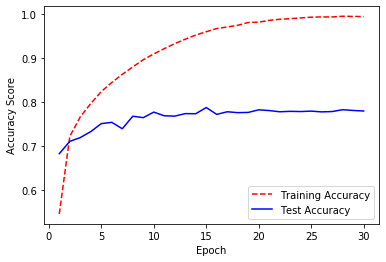

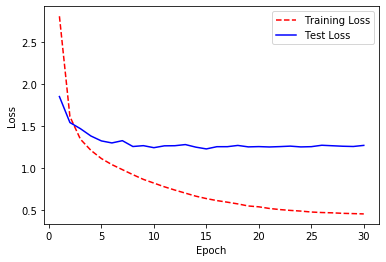

(None, None)

In [619]:
plot_accuracy(net_2lr), plot_loss(net_2lr)

#### Scores with using 1 to 5 models in ensemble

In [621]:
score_1 = accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)).argmax(axis=1)))
score_2 = accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr))/2).argmax(axis=1))
score_3 = accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr)+model_2gr.predict(valid_arr))/3).argmax(axis=1))
score_4 = accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr)+model_2gr.predict(valid_arr)+model_2jr.predict(valid_arr))/4).argmax(axis=1))
score_5 = accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr)+model_2gr.predict(valid_arr)+model_2jr.predict(valid_arr)+model_2lr.predict(valid_arr))/5).argmax(axis=1))
print(score_1,score_2,score_3,score_4,score_5)

0.7848320158102767 0.7971837944664032 0.8013833992094862 0.8023715415019763 0.804100790513834


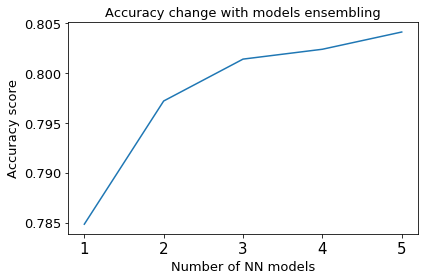

In [647]:
fig= plt.figure(figsize=(6,4))
plt.plot(range(1,6),[score_1,score_2,score_3,score_4,score_5])
plt.xticks(range(1,6), fontsize = 15)
plt.yticks(np.arange(0.785,0.807, 0.005), fontsize = 13)
plt.title('Accuracy change with models ensembling',fontsize = 13)
plt.xlabel('Number of NN models',fontsize = 13)
plt.ylabel('Accuracy score',fontsize = 13)
plt.tight_layout()
fig.savefig('ensemble.png', transparent = True)

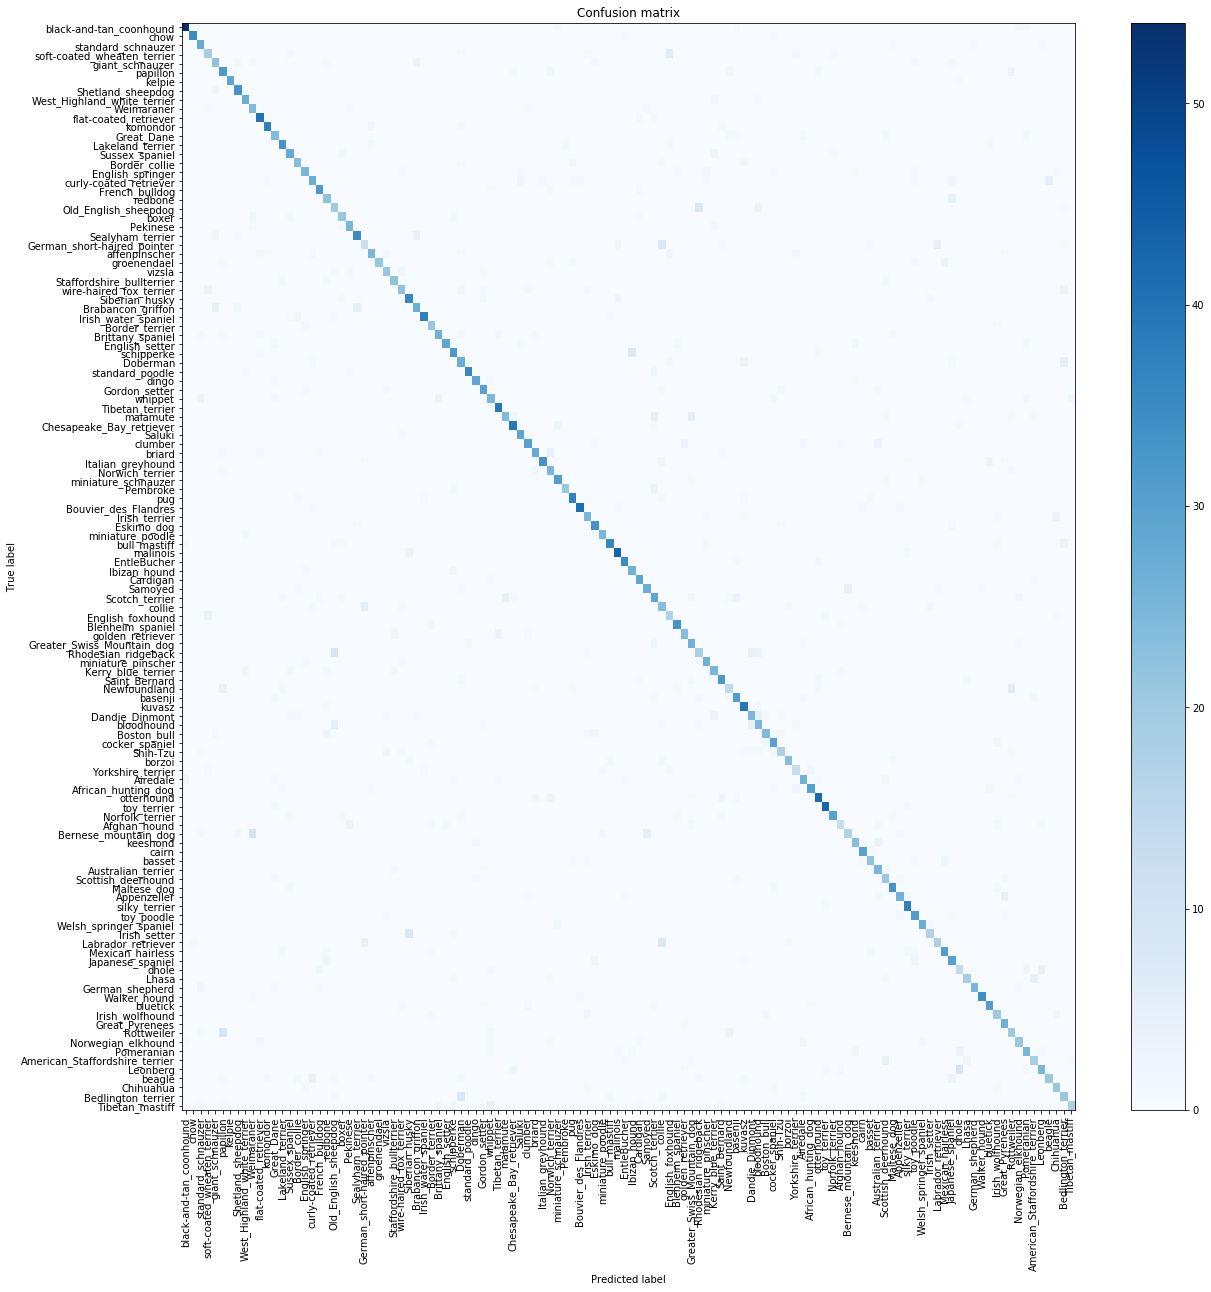

In [606]:
plot_confusion_matrix(confusion_matrix(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr)+model_2gr.predict(valid_arr)+model_2jr.predict(valid_arr)+model_2lr.predict(valid_arr))/5).argmax(axis=1)),list(y_table.columns))

In [ ]:
print('Validation for 5 NN models: Accuracy {}'.format(accuracy_score(valid_breeds, ((model_2cr.predict(valid_arr)+model_2dr.predict(valid_arr)+model_2gr.predict(valid_arr)+model_2jr.predict(valid_arr)+model_2lr.predict(valid_arr))/5).argmax(axis=1))))

Validation for 5 NN models: Accuracy 0.804100790513834

### Saving models to use for predictions

In [567]:
model_2lr.save("model_2lr.h5")

In [571]:
model_2cr.save("model_2cr.h5")
model_2dr.save("model_2dr.h5")
model_2gr.save("model_2gr.h5")
model_2jr.save("model_2jr.h5")